# Applied Data Science Capstone

**Neighborhood Clustering in Toronto**

In completion of requirements for the IBM Data Science Professional Certificate on Coursera

Daniel Nezich

<hr>

## Overview - Neighborhood Clustering in Toronto, CA

This project uses location and census data to group neighborhoods in Toronto, CA in order to assist, for example, in moving across town to a similar neighborhood or determining which area of the city might be most enjoyable to visit.

First, the locations to be grouped are defined as the Forward Sortation Area (FSA) regions of Canada Post.  A list of FSA and corresponding neighborhoods in Totronto is read from Wikipedia.  The geolocation service HERE is used to find a latitude and longitude for each FSA.

Second, features are generated for each location.  These come in two forms: numerical data from the Canada 2016 Census, and a list of nearby venues from Foursquare.  The numerical features are modified to approximate a normal distribution, and the list of venues is converted into categorical vectors.  Various levels of categorization are prepared for exploration.

Third, a k-means model is used to fit the features.  A range of feature sets is used to see how clustering performance is affected by feature choice, and for each feature set a range of cluster number is examined to determine the optimal cluster number via the gap statistic.

Fourth, an optimal model is selected and examined in detail, including determination of important predictive features by ANOVA p-value, cluster identification by average feature value, and cluster display on a map.

## Imports

In [1]:
# General
import pandas as pd
import numpy as np

# Postal Codes
import requests
# from bs4 import BeautifulSoup # had to install to environment in Anaconda
import lxml # had to install to environment in Anaconda, backdated to 4.6.1 (4.6.2 current) for pandas read_html()
import html5lib # had to install to environment in Anaconda (1.1 current) for pandas read_html()

# Geocoding
import config
from geopy.geocoders import Here
from geopy import distance
import matplotlib.pyplot as plt
%matplotlib inline

# Census Features
import folium
import matplotlib.pyplot as plt
%matplotlib inline

# Venue Features
import os
import dill
import config
import importlib
import requests
import matplotlib.pyplot as plt
%matplotlib inline

# K-Means Clustering
import sklearn.feature_selection
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Optimal K-Means Model
import folium
import matplotlib.cm as cm
import matplotlib.colors
from folium.features import DivIcon

## Table of Toronto Postal Codes (FSAs)

First we will use the Requests module to get the [webpage](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) containing the data we need.

In [2]:
import requests

In [3]:
url_wikipedia_postal_codes = 'https://web.archive.org/web/20201112041516/https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M' #'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [4]:
webpage = requests.get(url_wikipedia_postal_codes)

We could inspect webpage.text and extract the tables with BeautifulSoup (see appendix), but parsing tables from the webpage text can also be handled by Pandas.

Let's inspect the tables automatically parsed from the page:

In [5]:
df = pd.read_html(webpage.text)
for i, d in enumerate(df):
    print(f'Table {i}:')
    display(d.head())

Table 0:


Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

Table 1:


0   \
0                                                NaN   
1  NL NS PE NB QC ON MB SK AB BC NU/NT YT A B C E...   
2                                                 NL   
3                                                  A   

                                                  1   \
0                              Canadian postal codes   
1  NL NS PE NB QC ON MB SK AB BC NU/NT YT A B C E...   
2                                                 NS   
3                                                  B   

                                                  2    3    4    5    6    7   \
0                                                NaN  NaN  NaN  NaN  NaN  NaN   
1  NL NS PE NB QC ON MB SK AB BC NU/NT YT A B C E...  NaN  NaN  NaN  NaN  NaN   
2                                                 PE   NB   QC   QC   QC   ON   
3                                                  C    E    G    H    J    K   

    8    9    10   11   12   13   14   15     16   17  
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  
2   ON   ON   ON   ON   MB   SK   AB   BC  NU/NT   YT  
3    L    M    N    P    R    S    T    V      X    Y

Table 2:


0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15     16  17
0  NL  NS  PE  NB  QC  QC  QC  ON  ON  ON  ON  ON  MB  SK  AB  BC  NU/NT  YT
1   A   B   C   E   G   H   J   K   L   M   N   P   R   S   T   V      X   Y

By inspection, the table we want is at index 0 (current Wikipedia formatting has been updated to break this parsing, but the Internet Archive has the prior version, so the analysis is retained and the link above updated).

In [6]:
df = df[0].astype(str)
df.shape

(180, 3)

Let's clean up the columns.

First, the Postal Code is expected to be unique:

In [7]:
len(df['Postal Code'].unique()) == len(df['Postal Code'])

True

So rows are uniquely indexed by the Postal Code, as desired, and we do not have to combine neighborhoods into a comma separated list as per the assignment instructions - they already are.

Second, we take only the Borough that are not 'Not Assigned':

In [8]:
df = df[df['Borough']!='Not assigned'].reset_index(drop=True)
display(df.head())
df.shape

Postal Code           Borough                                Neighbourhood
0         M3A        North York                                    Parkwoods
1         M4A        North York                             Victoria Village
2         M5A  Downtown Toronto                    Regent Park, Harbourfront
3         M6A        North York             Lawrence Manor, Lawrence Heights
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

(103, 3)

So 77 Postal Codes were not assigned to a Borough.

We should also ensure that all Borough names are legitimate.  This must be done manually.

In [9]:
df['Borough'].unique()

array(['North York', 'Downtown Toronto', 'Etobicoke', 'Scarborough',
       'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

Those all look like Borough names, and there are 10 total.

Third, we want each entry in Neighborhood that is 'Not assigned' to be the Borough name.

In [10]:
def showalldf(df):
    old_opt = pd.get_option('display.max_rows')
    numel = len(df.index)
    pd.set_option('display.max_rows', len(df.index))
    display(df)
    pd.set_option('display.max_rows', old_opt)

In [11]:
print(f"There are {df[df['Neighbourhood']=='Not assigned'].size} Neighborhoods not assigned")
print('Neighborhoods are:')
showalldf(df['Neighbourhood'])

There are 0 Neighborhoods not assigned
Neighborhoods are:


0                                              Parkwoods
1                                       Victoria Village
2                              Regent Park, Harbourfront
3                       Lawrence Manor, Lawrence Heights
4            Queen's Park, Ontario Provincial Government
5                Islington Avenue, Humber Valley Village
6                                         Malvern, Rouge
7                                              Don Mills
8                        Parkview Hill, Woodbine Gardens
9                               Garden District, Ryerson
10                                             Glencairn
11     West Deane Park, Princess Gardens, Martin Grov...
12                Rouge Hill, Port Union, Highland Creek
13                                             Don Mills
14                                      Woodbine Heights
15                                        St. James Town
16                                    Humewood-Cedarvale
17     Eringate, Bloordale Gard

So all Neighbourhood entries look non-empty.

But on closer inspection there are entries that don't make sense for a neighborhood analysis, so we should drop them:
* Row 76: Canada Post Gateway Processing Centre
* Row 92: Stn A PO Boxes
* Row 100: Business reply mail Processing Centre, South Central Letter Processing Plant Toronto

These will actually be removed in a later step where we eliminate postal codes that have no residential space associated with them (like govenment buildings, office buildings, commercial plazas).  We will keep the full dataframe for now.  The drop on inspection was previously (and incompletely) performed with the line:

    df_cleaned = df.drop(index=[76, 92, 100]).reset_index(drop=True)

We conclude this section by displaying the final dataframe:

In [12]:
showalldf(df)

Postal Code           Borough  \
0           M3A        North York   
1           M4A        North York   
2           M5A  Downtown Toronto   
3           M6A        North York   
4           M7A  Downtown Toronto   
5           M9A         Etobicoke   
6           M1B       Scarborough   
7           M3B        North York   
8           M4B         East York   
9           M5B  Downtown Toronto   
10          M6B        North York   
11          M9B         Etobicoke   
12          M1C       Scarborough   
13          M3C        North York   
14          M4C         East York   
15          M5C  Downtown Toronto   
16          M6C              York   
17          M9C         Etobicoke   
18          M1E       Scarborough   
19          M4E      East Toronto   
20          M5E  Downtown Toronto   
21          M6E              York   
22          M1G       Scarborough   
23          M4G         East York   
24          M5G  Downtown Toronto   
25          M6G  Downtown Toronto   
26          M1H       Scarborough   
27          M2H        North York   
28          M3H        North York   
29          M4H         East York   
30          M5H  Downtown Toronto   
31          M6H      West Toronto   
32          M1J       Scarborough   
33          M2J        North York   
34          M3J        North York   
35          M4J         East York   
36          M5J  Downtown Toronto   
37          M6J      West Toronto   
38          M1K       Scarborough   
39          M2K        North York   
40          M3K        North York   
41          M4K      East Toronto   
42          M5K  Downtown Toronto   
43          M6K      West Toronto   
44          M1L       Scarborough   
45          M2L        North York   
46          M3L        North York   
47          M4L      East Toronto   
48          M5L  Downtown Toronto   
49          M6L        North York   
50          M9L        North York   
51          M1M       Scarborough   
52          M2M        North York   
53          M3M        North York   
54          M4M      East Toronto   
55          M5M        North York   
56          M6M              York   
57          M9M        North York   
58          M1N       Scarborough   
59          M2N        North York   
60          M3N        North York   
61          M4N   Central Toronto   
62          M5N   Central Toronto   
63          M6N              York   
64          M9N              York   
65          M1P       Scarborough   
66          M2P        North York   
67          M4P   Central Toronto   
68          M5P   Central Toronto   
69          M6P      West Toronto   
70          M9P         Etobicoke   
71          M1R       Scarborough   
72          M2R        North York   
73          M4R   Central Toronto   
74          M5R   Central Toronto   
75          M6R      West Toronto   
76          M7R       Mississauga   
77          M9R         Etobicoke   
78          M1S       Scarborough   
79          M4S   Central Toronto   
80          M5S  Downtown Toronto   
81          M6S      West Toronto   
82          M1T       Scarborough   
83          M4T   Central Toronto   
84          M5T  Downtown Toronto   
85          M1V       Scarborough   
86          M4V   Central Toronto   
87          M5V  Downtown Toronto   
88          M8V         Etobicoke   
89          M9V         Etobicoke   
90          M1W       Scarborough   
91          M4W  Downtown Toronto   
92          M5W  Downtown Toronto   
93          M8W         Etobicoke   
94          M9W         Etobicoke   
95          M1X       Scarborough   
96          M4X  Downtown Toronto   
97          M5X  Downtown Toronto   
98          M8X         Etobicoke   
99          M4Y  Downtown Toronto   
100         M7Y      East Toronto   
101         M8Y         Etobicoke   
102         M8Z         Etobicoke   

                                         Neighbourhood  
0                                            Parkwoods  
1                                     Vic

And finally, the postal codes dataframe shape is:

In [13]:
df.shape

(103, 3)

## Latitude and Longitude for each Toronto Postal Code

After looking through many geopy and geocoder options (see Appendix), I chose to use Nominatim.  While Nominatim doesn't succeed for partial postal code lookup, it did succeed with many neighborhoods.  Sevearal missed assignments were due to using slightly different names, but there were still over 80 imperfectly assigned neighborhood locations.

I then tried using a commercial service.  Google appears to charge for any developer use, but HERE has a freemium service which I did sign up for.  With an API key I was able to get geopy to geocode a partial postal code, so I'll be continuing work there.  Note that the geocoder module does not seem to work, possibly due to a misconfigured web address for requests (based on the errors returned).

To keep api keys secret, they are stored in a config.py file listed in the .gitignore file on GitHub.

To reload the configuration file should it need to be changed in development, run:

    import importlib
    importlib.reload(config)

For HERE, we need supply just the REST API key (on their site, called the app code)

In [14]:
import config # Local python file storing API keys

In [15]:
from geopy.geocoders import Here
gc = Here(apikey=config.HERE_APIKEY)

Now we can try to geocode the postal codes

In [16]:
df_c = df.copy(deep=True)
for i, row in df_c.iterrows():
    g = gc.geocode(f"{row['Postal Code']}, Ontario")
    if g!=None:
        df_c.loc[i,'GString'] = g[0]
        df_c.loc[i,'Latitude'] = g[1][0]
        df_c.loc[i,'Longitude'] = g[1][1]
    else:
        print(f"Geocoding failed for Postal Code: {row['Postal Code']}, Borough: {row['Borough']}, Neighborhoods: {row['Neighbourhood']}")

Geocoding failed for Postal Code: M7R, Borough: Mississauga, Neighborhoods: Canada Post Gateway Processing Centre
Geocoding failed for Postal Code: M5W, Borough: Downtown Toronto, Neighborhoods: Stn A PO Boxes
Geocoding failed for Postal Code: M7Y, Borough: East Toronto, Neighborhoods: Business reply mail Processing Centre, South Central Letter Processing Plant Toronto


Offline inspection for missing values:

In [17]:
print(f"There are {df_c[df_c['GString']==None].shape[0]} rows where geocoding failed")
df_tmp = df_c['GString'].copy()
for i, val in enumerate(df_tmp):
    if pd.isnull(val):
        df_tmp[i] = -1
    else:
        df_tmp[i] = val.find(df_c.loc[i,'Postal Code'])
print(f"There are {sum(df_tmp==-1)} rows where the postal code is not found in the geocoded Location")
if sum(df_tmp==-1)>0:
    print(f"The geocoding failed at indices {df_tmp[df_tmp==-1].index.to_list()}, entries shown below:")
    display(df_c.loc[df_tmp==-1,:])

There are 0 rows where geocoding failed
There are 3 rows where the postal code is not found in the geocoded Location
The geocoding failed at indices [76, 92, 100], entries shown below:


Postal Code           Borough  \
76          M7R       Mississauga   
92          M5W  Downtown Toronto   
100         M7Y      East Toronto   

                                         Neighbourhood GString  Latitude  \
76               Canada Post Gateway Processing Centre     NaN       NaN   
92                                      Stn A PO Boxes     NaN       NaN   
100  Business reply mail Processing Centre, South C...     NaN       NaN   

     Longitude  
76         NaN  
92         NaN  
100        NaN

Wow, that was so much easier than trying to massage the Nominatim data (see Appendix).

Note that these three indices are the ones we previously considered for removal by manual inspection of the neighborhood list.  We can remove them here.

In [18]:
df_c.drop(index=df_tmp[df_tmp==-1].index.to_list(), inplace=True)
df_c.reset_index(drop=True, inplace=True)
df_c.shape

(100, 6)

Let's load up a csv file of locations and see if it matches.

In [19]:
df_gt = pd.read_csv('Geospatial_Coordinates.csv')
df_gt.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [20]:
df_gt.shape

(103, 3)

In [21]:
df_gt.rename(columns={'Latitude':'GT Latitude','Longitude':'GT Longitude'}, inplace=True)
df_gt.head()

Postal Code  GT Latitude  GT Longitude
0         M1B    43.806686    -79.194353
1         M1C    43.784535    -79.160497
2         M1E    43.763573    -79.188711
3         M1G    43.770992    -79.216917
4         M1H    43.773136    -79.239476

In [22]:
df_d = df_c.merge(df_gt, on='Postal Code')
df_d

Postal Code           Borough  \
0          M3A        North York   
1          M4A        North York   
2          M5A  Downtown Toronto   
3          M6A        North York   
4          M7A  Downtown Toronto   
..         ...               ...   
95         M5X  Downtown Toronto   
96         M8X         Etobicoke   
97         M4Y  Downtown Toronto   
98         M8Y         Etobicoke   
99         M8Z         Etobicoke   

                                        Neighbourhood  \
0                                           Parkwoods   
1                                    Victoria Village   
2                           Regent Park, Harbourfront   
3                    Lawrence Manor, Lawrence Heights   
4         Queen's Park, Ontario Provincial Government   
..                                                ...   
95             First Canadian Place, Underground city   
96      The Kingsway, Montgomery Road, Old Mill North   
97                               Church and Wellesley   
98  Old Mill South, King's Mill Park, Sunnylea, Hu...   
99  Mimico NW, The Queensway West, South of Bloor,...   

                                           GString  Latitude  Longitude  \
0   M3A, Toronto, ON, Canada, Toronto, ON M3A, CAN  43.74998  -79.32760   
1   M4A, Toronto, ON, Canada, Toronto, ON M4A, CAN  43.73064  -79.31297   
2   M5A, Toronto, ON, Canada, Toronto, ON M5A, CAN  43.65512  -79.36264   
3   M6A, Toronto, ON, Canada, Toronto, ON M6A, CAN  43.72329  -79.45099   
4   M7A, Toronto, ON, Canada, Toronto, ON M7A, CAN  43.66189  -79.39172   
..                                             ...       ...        ...   
95  M5X, Toronto, ON, Canada, Toronto, ON M5X, CAN  43.64798  -79.38144   
96  M8X, Toronto, ON, Canada, Toronto, ON M8X, CAN  43.65322  -79.51114   
97  M4Y, Toronto, ON, Canada, Toronto, ON M4Y, CAN  43.66659  -79.38133   
98  M8Y, Toronto, ON, Canada, Toronto, ON M8Y, CAN  43.63299  -79.48968   
99  M8Z, Toronto, ON, Canada, Toronto, ON M8Z, CAN  43.62517  -79.52703   

    GT Latitude  GT Longitude  
0     43.753259    -79.329656  
1     43.725882    -79.315572  
2     43.654260    -79.360636  
3     43.718518    -79.464763  
4     43.662301    -79.389494  
..          ...           ...  
95    43.648429    -79.382280  
96    43.653654    -79.506944  
97    43.665860    -79.383160  
98    43.636258    -79.498509  
99    43.628841    -79.520999  

[100 rows x 8 columns]

In [23]:
df_d['Diff Lat'] = df_d['Latitude']-df_d['GT Latitude']
df_d['Diff Lon'] = df_d['Longitude']-df_d['GT Longitude']
df_d.head()

Postal Code           Borough                                Neighbourhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

                                          GString  Latitude  Longitude  \
0  M3A, Toronto, ON, Canada, Toronto, ON M3A, CAN  43.74998  -79.32760   
1  M4A, Toronto, ON, Canada, Toronto, ON M4A, CAN  43.73064  -79.31297   
2  M5A, Toronto, ON, Canada, Toronto, ON M5A, CAN  43.65512  -79.36264   
3  M6A, Toronto, ON, Canada, Toronto, ON M6A, CAN  43.72329  -79.45099   
4  M7A, Toronto, ON, Canada, Toronto, ON M7A, CAN  43.66189  -79.39172   

   GT Latitude  GT Longitude  Diff Lat  Diff Lon  
0    43.753259    -79.329656 -0.003279  0.002056  
1    43.725882    -79.315572  0.004758  0.002602  
2    43.654260    -79.360636  0.000860 -0.002004  
3    43.718518    -79.464763  0.004772  0.013773  
4    43.662301    -79.389494 -0.000411 -0.002226

In [24]:
print(f"Latitude difference:  {df_d['Diff Lat'].abs().mean():0.5f} +/- {df_d['Diff Lat'].abs().std():0.5f} with maximum {df_d['Diff Lat'].abs().max():0.5f}")
print(f"Longitude difference: {df_d['Diff Lon'].abs().mean():0.5f} +/- {df_d['Diff Lon'].abs().std():0.5f} with maximum {df_d['Diff Lon'].abs().max():0.5f}")

Latitude difference:  0.00261 +/- 0.00263 with maximum 0.01816
Longitude difference: 0.00356 +/- 0.00321 with maximum 0.01551


What do these differences mean in terms of distance?

In [25]:
from geopy import distance
for i, row in df_d.iterrows():
    df_d.loc[i,'GT Diff Meters'] = distance.distance((row['Latitude'],row['Longitude']),(row['GT Latitude'],row['GT Longitude'])).meters
print(f"Differences: {df_d['GT Diff Meters'].mean():0.1f} +/- {df_d['GT Diff Meters'].std():0.1f} meters with maximum {df_d['GT Diff Meters'].max():0.1f} meters and minimum {df_d['GT Diff Meters'].min():0.1f} meters")
df_d.head()

Differences: 444.2 +/- 347.6 meters with maximum 2127.8 meters and minimum 13.4 meters


Postal Code           Borough                                Neighbourhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

                                          GString  Latitude  Longitude  \
0  M3A, Toronto, ON, Canada, Toronto, ON M3A, CAN  43.74998  -79.32760   
1  M4A, Toronto, ON, Canada, Toronto, ON M4A, CAN  43.73064  -79.31297   
2  M5A, Toronto, ON, Canada, Toronto, ON M5A, CAN  43.65512  -79.36264   
3  M6A, Toronto, ON, Canada, Toronto, ON M6A, CAN  43.72329  -79.45099   
4  M7A, Toronto, ON, Canada, Toronto, ON M7A, CAN  43.66189  -79.39172   

   GT Latitude  GT Longitude  Diff Lat  Diff Lon  GT Diff Meters  
0    43.753259    -79.329656 -0.003279  0.002056      400.163722  
1    43.725882    -79.315572  0.004758  0.002602      568.656678  
2    43.654260    -79.360636  0.000860 -0.002004      187.801580  
3    43.718518    -79.464763  0.004772  0.013773     1230.009537  
4    43.662301    -79.389494 -0.000411 -0.002226      185.294364

That's a very big difference!  Though most are smaller, we'd still like some confidence in knowing which to use.

Manually inspecting Google Maps, the outline for M6A postal code has the HERE Lat/Long at the center, and the csv value near the left edge of the zone.  For M8Y, both HERE and csv are a little off, though HERE is probably closer.  Ideally with the postal code polygons we could find the center of mass, but that level of exactness won't help us.

Let's look at the distribution of nearest-neighbor distances, since this might inform our choice of neighborhood radius.

In [26]:
dist_matrix = []
for i, row in df_d.iterrows():
    # This implementation is slow by a factor of 2, look into distance matrix functions
    dist_matrix.append([distance.distance((row['Latitude'],row['Longitude']),(x['Latitude'],x['Longitude'])).meters for j, x in df_d.iterrows()])
    df_d.loc[i,'NN Distance'] = min([x for x in dist_matrix[-1] if x > 0])
    df_d.loc[i,'NN Index'] = np.argmin(np.array([(9999999 if x==0 else x) for x in dist_matrix[-1]]))
dist_nn = [min([x for x in y if x > 0]) for y in dist_matrix]
df_d['NN Index'] = df_d['NN Index'].astype(int)
df_d.head()

Postal Code           Borough                                Neighbourhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

                                          GString  Latitude  Longitude  \
0  M3A, Toronto, ON, Canada, Toronto, ON M3A, CAN  43.74998  -79.32760   
1  M4A, Toronto, ON, Canada, Toronto, ON M4A, CAN  43.73064  -79.31297   
2  M5A, Toronto, ON, Canada, Toronto, ON M5A, CAN  43.65512  -79.36264   
3  M6A, Toronto, ON, Canada, Toronto, ON M6A, CAN  43.72329  -79.45099   
4  M7A, Toronto, ON, Canada, Toronto, ON M7A, CAN  43.66189  -79.39172   

   GT Latitude  GT Longitude  Diff Lat  Diff Lon  GT Diff Meters  NN Distance  \
0    43.753259    -79.329656 -0.003279  0.002056      400.163722  2179.358574   
1    43.725882    -79.315572  0.004758  0.002602      568.656678  2443.750415   
2    43.654260    -79.360636  0.000860 -0.002004      187.801580  1115.710823   
3    43.718518    -79.464763  0.004772  0.013773     1230.009537  1827.071490   
4    43.662301    -79.389494 -0.000411 -0.002226      185.294364   824.268954   

   NN Index  
0        71  
1        71  
2        15  
3        40  
4        79

Text(0.5, 1.0, 'Toronto Postal Code Nearest-Neighbor Distances')

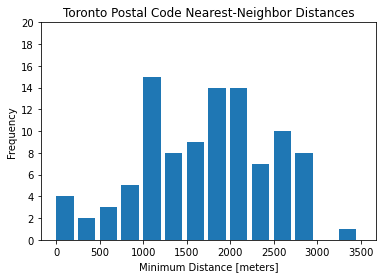

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

ax = df_d['NN Distance'].plot(kind='hist', bins=np.arange(0,3750,250), width=200)
plt.yticks(np.arange(0,22,2));
plt.xlabel('Minimum Distance [meters]')
plt.title('Toronto Postal Code Nearest-Neighbor Distances')

Large separations make sense for some of the larger neighborhoods, but is there something causing the short distances?

Let's inspect all postal codes with separation less than 'raidus' meters:

In [28]:
radius = 500
showalldf(df_d[df_d['NN Distance']<radius])

Postal Code           Borough  \
15         M5C  Downtown Toronto   
30         M5H  Downtown Toronto   
36         M5J  Downtown Toronto   
42         M5K  Downtown Toronto   
48         M5L  Downtown Toronto   
95         M5X  Downtown Toronto   

                                        Neighbourhood  \
15                                     St. James Town   
30                           Richmond, Adelaide, King   
36  Harbourfront East, Union Station, Toronto Islands   
42           Toronto Dominion Centre, Design Exchange   
48                     Commerce Court, Victoria Hotel   
95             First Canadian Place, Underground city   

                                           GString  Latitude  Longitude  \
15  M5C, Toronto, ON, Canada, Toronto, ON M5C, CAN  43.65190  -79.37574   
30  M5H, Toronto, ON, Canada, Toronto, ON M5H, CAN  43.64991  -79.38296   
36  M5J, Toronto, ON, Canada, Toronto, ON M5J, CAN  43.64325  -79.38062   
42  M5K, Toronto, ON, Canada, Toronto, ON M5K, CAN  43.64712  -79.38143   
48  M5L, Toronto, ON, Canada, Toronto, ON M5L, CAN  43.64832  -79.37902   
95  M5X, Toronto, ON, Canada, Toronto, ON M5X, CAN  43.64798  -79.38144   

    GT Latitude  GT Longitude  Diff Lat  Diff Lon  GT Diff Meters  \
15    43.651494    -79.375418  0.000406 -0.000322       52.067561   
30    43.650571    -79.384568 -0.000661  0.001608      149.048218   
36    43.640816    -79.381752  0.002434  0.001132      285.477634   
42    43.647177    -79.381576 -0.000057  0.000146       13.391742   
48    43.648198    -79.379817  0.000121  0.000797       65.694621   
95    43.648429    -79.382280 -0.000449  0.000840       84.177334   

    NN Distance  NN Index  
15   477.737684        48  
30   247.021834        95  
36   434.915762        42  
42    95.554018        95  
48   198.863241        95  
95    95.554018        42

As could be expected, Downtown Toronto is the densest area of the city.  First Canadian Place and Underground city are an office building and an extensive network of underground tunnels and shops - a hiccup for Euclidian analysis.  What happens if we drop that neighborhood?

In [29]:
ind_remove = 95
dist_matrix = [[e for j, e in enumerate(d) if j!=ind_remove] for i, d in enumerate(dist_matrix) if i!=ind_remove]
dist_nn = [min([x for x in y if x > 0]) for y in dist_matrix]
dist_nn_index = [np.argmin(np.array([(9999999 if x==0 else x) for x in d])) for d in dist_matrix]

In [30]:
df_e = df_d.copy()
df_e.drop(index=95, inplace=True)
df_e.reset_index(drop=True, inplace=True)
df_e['NN Distance'] = dist_nn
df_e['NN Index'] = dist_nn_index
df_e.tail()

Postal Code           Borough  \
94         M4X  Downtown Toronto   
95         M8X         Etobicoke   
96         M4Y  Downtown Toronto   
97         M8Y         Etobicoke   
98         M8Z         Etobicoke   

                                        Neighbourhood  \
94                        St. James Town, Cabbagetown   
95      The Kingsway, Montgomery Road, Old Mill North   
96                               Church and Wellesley   
97  Old Mill South, King's Mill Park, Sunnylea, Hu...   
98  Mimico NW, The Queensway West, South of Bloor,...   

                                           GString  Latitude  Longitude  \
94  M4X, Toronto, ON, Canada, Toronto, ON M4X, CAN  43.66788  -79.36649   
95  M8X, Toronto, ON, Canada, Toronto, ON M8X, CAN  43.65322  -79.51114   
96  M4Y, Toronto, ON, Canada, Toronto, ON M4Y, CAN  43.66659  -79.38133   
97  M8Y, Toronto, ON, Canada, Toronto, ON M8Y, CAN  43.63299  -79.48968   
98  M8Z, Toronto, ON, Canada, Toronto, ON M8Z, CAN  43.62517  -79.52703   

    GT Latitude  GT Longitude  Diff Lat  Diff Lon  GT Diff Meters  \
94    43.667967    -79.367675 -0.000087  0.001185       96.084488   
95    43.653654    -79.506944 -0.000434 -0.004196      341.940892   
96    43.665860    -79.383160  0.000730  0.001830      168.412786   
97    43.636258    -79.498509 -0.003268  0.008829      799.659159   
98    43.628841    -79.520999 -0.003671 -0.006031      634.999798   

    NN Distance  NN Index  
94  1205.443164        96  
95  1734.688927         5  
96   987.410477         4  
97  2216.522451        80  
98  2889.063851        87

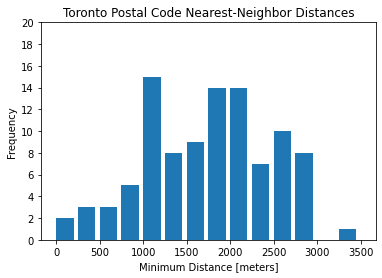

In [31]:
ax = df_e['NN Distance'].plot(kind='hist', bins=np.arange(0,3750,250), width=200)
plt.yticks(np.arange(0,22,2))
plt.xlabel('Minimum Distance [meters]')
plt.title('Toronto Postal Code Nearest-Neighbor Distances');

In [32]:
radius = 500
showalldf(df_e[df_e['NN Distance']<radius])

Postal Code           Borough  \
15         M5C  Downtown Toronto   
30         M5H  Downtown Toronto   
36         M5J  Downtown Toronto   
42         M5K  Downtown Toronto   
48         M5L  Downtown Toronto   

                                        Neighbourhood  \
15                                     St. James Town   
30                           Richmond, Adelaide, King   
36  Harbourfront East, Union Station, Toronto Islands   
42           Toronto Dominion Centre, Design Exchange   
48                     Commerce Court, Victoria Hotel   

                                           GString  Latitude  Longitude  \
15  M5C, Toronto, ON, Canada, Toronto, ON M5C, CAN  43.65190  -79.37574   
30  M5H, Toronto, ON, Canada, Toronto, ON M5H, CAN  43.64991  -79.38296   
36  M5J, Toronto, ON, Canada, Toronto, ON M5J, CAN  43.64325  -79.38062   
42  M5K, Toronto, ON, Canada, Toronto, ON M5K, CAN  43.64712  -79.38143   
48  M5L, Toronto, ON, Canada, Toronto, ON M5L, CAN  43.64832  -79.37902   

    GT Latitude  GT Longitude  Diff Lat  Diff Lon  GT Diff Meters  \
15    43.651494    -79.375418  0.000406 -0.000322       52.067561   
30    43.650571    -79.384568 -0.000661  0.001608      149.048218   
36    43.640816    -79.381752  0.002434  0.001132      285.477634   
42    43.647177    -79.381576 -0.000057  0.000146       13.391742   
48    43.648198    -79.379817  0.000121  0.000797       65.694621   

    NN Distance  NN Index  
15   477.737684        48  
30   333.656904        42  
36   434.915762        42  
42   235.757645        48  
48   235.757645        42

So there are still relatively small distances between neighborhoods in downtown Toronto.  Let's stay with the original list anyway.

For feature generation, we can consider that larger areas (more separated neighborhoods) are probably less dense, and to get a sampling of amenities we may need to query on larger distances.

But before moving on to that, let's add a couple of extra interesting features not from Foursquare, such as population density.

## Census Features

We collect some simple features from the 2016 census:
* [Population and dwelling count](https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/comprehensive.cfm)
* [FSA Area](https://mdl.library.utoronto.ca/collections/numeric-data/census-canada/2016/geo)

Begin by loading the relevant data into a dataframe:

In [33]:
def urlToFile(url, filename, overwrite=True, verbose=False):
    '''Downloads from a url and saves it to filename
    
    Returns True if file was written, False otherwise
    '''
    try:
        path = os.path.dirname(filename) if os.path.isabs(filename) else os.path.dirname(os.path.join(os.getcwd(),filename))
        if not os.path.exists(path):
            os.makedirs(path, exist_ok=True)
        if os.path.isfile(filename) and not overwrite:
            if verbose: print('File exists and will not be overwritten')
            return False
        response = requests.get(url)
        if response.status_code==200:
            with open(filename,'w+b') as f:
                for chunk in response:
                    f.write(chunk)
            if verbose: print('File saved from url')
            return True
        if verbose: print('File not downloaded.  Status code:',response.status_code)
        return False
    except BaseException as e:
        if verbose: print('Error saving file from url:',e)
        return False

In [34]:
census_url = 'https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Tables/CompFile.cfm?Lang=Eng&T=1201&OFT=FULLCSV'
urlToFile(census_url,'T1201EN.csv',overwrite=False,verbose=True);

File exists and will not be overwritten


In [35]:
area_url = 'https://mdl.library.utoronto.ca/sites/default/public/mdldata/open/canada/national/statcan/geo/2016/ref_products/ut/fsa_area_2016.csv'
urlToFile(area_url,'fsa_area_2016.csv',overwrite=False,verbose=True);

File exists and will not be overwritten


In [36]:
# 2016 Census data: FSA population and dwelling number, downloaded from https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/comprehensive.cfm
df_fsa_population = pd.read_csv('T1201EN.csv',header=0,skiprows=[1],skipfooter=8,engine='python')
df_fsa_population.rename(columns={'Geographic code':'Postal Code','Population, 2016':'Population','Total private dwellings, 2016':'Total Dwellings','Private dwellings occupied by usual residents, 2016':'Occupied Dwellings'},inplace=True)
df_fsa_population = df_fsa_population[['Postal Code','Population','Total Dwellings','Occupied Dwellings']]

# 2016 Census data: FSA area in square kilometers, downloaded from https://mdl.library.utoronto.ca/collections/numeric-data/census-canada/2016/geo
df_fsa_area = pd.read_csv('fsa_area_2016.csv',header=1)
df_fsa_area.rename(columns={'CFSAUID':'Postal Code','Area Sq Km':'Square km'},inplace=True)
df_fsa_area = df_fsa_area[['Postal Code','Square km']]

df_g = df_c.merge(df_fsa_population,how='left',on='Postal Code')
df_g = df_g.merge(df_fsa_area,how='left',on='Postal Code')

print('Dataframe shape:',df_g.shape)
df_g.head()

Dataframe shape: (100, 10)


Postal Code           Borough                                Neighbourhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

                                          GString  Latitude  Longitude  \
0  M3A, Toronto, ON, Canada, Toronto, ON M3A, CAN  43.74998  -79.32760   
1  M4A, Toronto, ON, Canada, Toronto, ON M4A, CAN  43.73064  -79.31297   
2  M5A, Toronto, ON, Canada, Toronto, ON M5A, CAN  43.65512  -79.36264   
3  M6A, Toronto, ON, Canada, Toronto, ON M6A, CAN  43.72329  -79.45099   
4  M7A, Toronto, ON, Canada, Toronto, ON M7A, CAN  43.66189  -79.39172   

   Population  Total Dwellings  Occupied Dwellings  Square km  
0       34615            13847               13241   7.818049  
1       14443             6299                6170   4.723358  
2       41078            24186               22333   4.297526  
3       21048             8751                8074   5.829964  
4          10                6                   5        NaN

Let's examine any missing values.

In [37]:
display(df_g.loc[df_g['Square km'].isnull(),:])
print(f"Missing values at indices: {df_g.loc[df_g['Square km'].isnull(),:].index.to_list()}")

Postal Code           Borough                                Neighbourhood  \
4          M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   
42         M5K  Downtown Toronto     Toronto Dominion Centre, Design Exchange   
48         M5L  Downtown Toronto               Commerce Court, Victoria Hotel   
95         M5X  Downtown Toronto       First Canadian Place, Underground city   

                                           GString  Latitude  Longitude  \
4   M7A, Toronto, ON, Canada, Toronto, ON M7A, CAN  43.66189  -79.39172   
42  M5K, Toronto, ON, Canada, Toronto, ON M5K, CAN  43.64712  -79.38143   
48  M5L, Toronto, ON, Canada, Toronto, ON M5L, CAN  43.64832  -79.37902   
95  M5X, Toronto, ON, Canada, Toronto, ON M5X, CAN  43.64798  -79.38144   

    Population  Total Dwellings  Occupied Dwellings  Square km  
4           10                6                   5        NaN  
42           0                1                   1        NaN  
48           0                1                   1        NaN  
95          10                5                   3        NaN

Missing values at indices: [4, 42, 48, 95]


In [38]:
df_h = df_g.copy(deep=True)
df_h.drop(index=df_g.loc[df_g['Square km'].isnull(),:].index, inplace=True)
df_h.reset_index( drop=True, inplace=True)
print('Dataframe shape:',df_h.shape)
df_h.head()

Dataframe shape: (96, 10)


Postal Code           Borough                            Neighbourhood  \
0         M3A        North York                                Parkwoods   
1         M4A        North York                         Victoria Village   
2         M5A  Downtown Toronto                Regent Park, Harbourfront   
3         M6A        North York         Lawrence Manor, Lawrence Heights   
4         M9A         Etobicoke  Islington Avenue, Humber Valley Village   

                                          GString  Latitude  Longitude  \
0  M3A, Toronto, ON, Canada, Toronto, ON M3A, CAN  43.74998  -79.32760   
1  M4A, Toronto, ON, Canada, Toronto, ON M4A, CAN  43.73064  -79.31297   
2  M5A, Toronto, ON, Canada, Toronto, ON M5A, CAN  43.65512  -79.36264   
3  M6A, Toronto, ON, Canada, Toronto, ON M6A, CAN  43.72329  -79.45099   
4  M9A, Toronto, ON, Canada, Toronto, ON M9A, CAN  43.66263  -79.52830   

   Population  Total Dwellings  Occupied Dwellings  Square km  
0       34615            13847               13241   7.818049  
1       14443             6299                6170   4.723358  
2       41078            24186               22333   4.297526  
3       21048             8751                8074   5.829964  
4       35594            15730               15119  10.651703

So four more irrelevant postal codes are found.  Note that the previous three would appear in this list as well, as they also have no entry for land area.

Let's drop these four new rows, since they are clearly not relevant from a residential standpoint.  It could be argued that there may be residences nearby, but as noted previously for Downtown Toronto, the density is high and the remaining postal codes should capture any neighborhood differences.

We should use the new population, dwelling, and area features to compute features more suitable for comparison:
* Population Density = Population / Square km
* Residentiality = Occupied Dwellings / Total Dwellings
* Dwelling Density = Population / Occupied Dwellings

In [39]:
df_h['Population Density'] = df_h['Population']/df_h['Square km']
df_h['Residentiality'] = df_h['Occupied Dwellings']/df_h['Total Dwellings']
df_h['Dwelling Density'] = df_h['Population']/df_h['Occupied Dwellings']
df_h.head(1)

Postal Code     Borough Neighbourhood  \
0         M3A  North York     Parkwoods   

                                          GString  Latitude  Longitude  \
0  M3A, Toronto, ON, Canada, Toronto, ON M3A, CAN  43.74998   -79.3276   

   Population  Total Dwellings  Occupied Dwellings  Square km  \
0       34615            13847               13241   7.818049   

   Population Density  Residentiality  Dwelling Density  
0         4427.575256        0.956236          2.614229

Let's visualize how these new features are distributed:

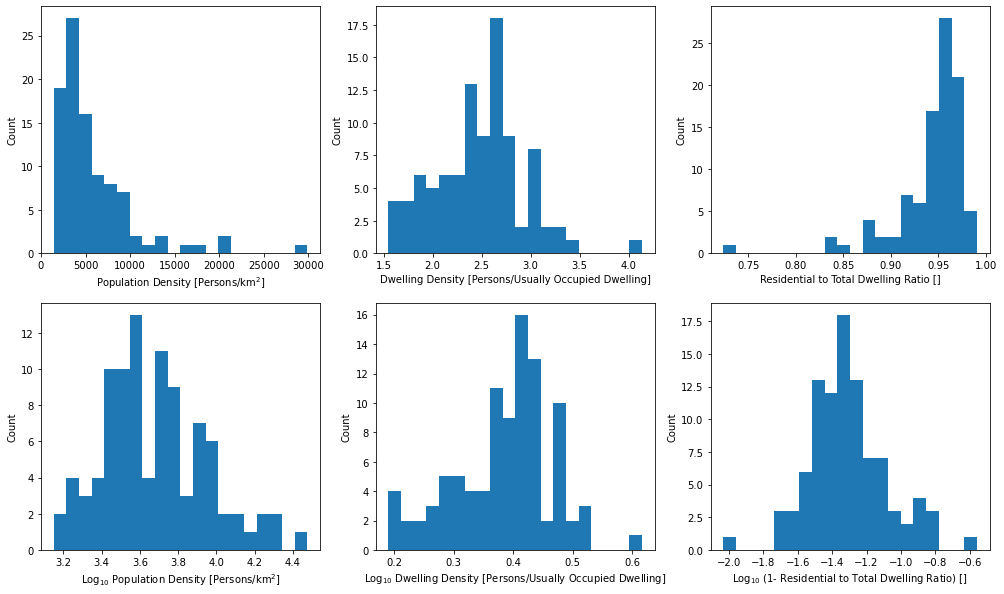

In [40]:
fig, axs = plt.subplots(2,3,figsize=(17,10))

ax = axs[0][0]
ax.hist(df_h['Population Density'],bins=20)
ax.set_xlabel('Population Density [Persons/km$^2$]')
ax.set_ylabel('Count')
ax = axs[1][0]
ax.hist(df_h['Population Density'].apply(np.log10),bins=20)
ax.set_xlabel('Log$_{10}$ Population Density [Persons/km$^2$]')
ax.set_ylabel('Count')

ax = axs[0][1]
ax.hist(df_h['Dwelling Density'],bins=20)
ax.set_xlabel('Dwelling Density [Persons/Usually Occupied Dwelling]')
ax.set_ylabel('Count')
ax = axs[1][1]
ax.hist(df_h['Dwelling Density'].apply(np.log10),bins=20)
ax.set_xlabel('Log$_{10}$ Dwelling Density [Persons/Usually Occupied Dwelling]')
ax.set_ylabel('Count')

ax = axs[0][2]
ax.hist(df_h['Residentiality'],bins=20)
ax.set_xlabel('Residential to Total Dwelling Ratio []')
ax.set_ylabel('Count')
ax = axs[1][2]
ax.hist((1-df_h['Residentiality']).apply(np.log10),bins=20)
ax.set_xlabel('Log$_{10}$ (1- Residential to Total Dwelling Ratio) []')
ax.set_ylabel('Count');

So that our variables are near-normally distributed, we should keep log$_{10}$ Population Density, unmodified Dwelling Density, and log$_{10}$ of 1 - the Residential to Total Dwelling Ratio.  The ranges will be adjusted using scalers during the classification.  Interestingly, the Population Density shows some evidence of clustering (though with only single low bins between the peaks, this may just be an artifact.

Let's construct and keep those variables in the dataframe:

In [41]:
df_h['Log10 (Population Density)'] = df_h['Population Density'].apply(np.log10)
df_h['Log10 (1 - Residentiality)'] = (1-df_h['Residentiality']).apply(np.log10)
df_h.head(1)

Postal Code     Borough Neighbourhood  \
0         M3A  North York     Parkwoods   

                                          GString  Latitude  Longitude  \
0  M3A, Toronto, ON, Canada, Toronto, ON M3A, CAN  43.74998   -79.3276   

   Population  Total Dwellings  Occupied Dwellings  Square km  \
0       34615            13847               13241   7.818049   

   Population Density  Residentiality  Dwelling Density  \
0         4427.575256        0.956236          2.614229   

   Log10 (Population Density)  Log10 (1 - Residentiality)  
0                    3.646166                   -1.358883

Let's also recompute the nearest neighbor distance and index, since the number of rows has been reduced since we last did that.

In [42]:
def getNN(lat,lon):
    # Returns the NN distance in meters and index of NN given input arrays of latitude and longitude as Pandas series
    assert len(lat)==len(lon)
    dist_matrix = []
    for i in range(len(lat)):
        # This implementation is slow by a factor of 2, look into distance matrix functions
        dist_matrix.append([distance.distance((lat[i],lon[i]),(lat[j],lon[j])).meters for j in range(len(lat))])
    nn_dist = pd.Series(data=[min([x for x in y if x > 0]) for y in dist_matrix],name='NN Distance [m]')
    nn_index = pd.Series(data=[np.argmin(np.array([(9999999 if x==0 else x) for x in d])) for d in dist_matrix],name='NN Index',dtype=int)
    return nn_dist, nn_index

In [43]:
df_h = pd.concat([df_h,*getNN(df_h['Latitude'],df_h['Longitude'])],axis=1)
df_h.head()

Postal Code           Borough                            Neighbourhood  \
0         M3A        North York                                Parkwoods   
1         M4A        North York                         Victoria Village   
2         M5A  Downtown Toronto                Regent Park, Harbourfront   
3         M6A        North York         Lawrence Manor, Lawrence Heights   
4         M9A         Etobicoke  Islington Avenue, Humber Valley Village   

                                          GString  Latitude  Longitude  \
0  M3A, Toronto, ON, Canada, Toronto, ON M3A, CAN  43.74998  -79.32760   
1  M4A, Toronto, ON, Canada, Toronto, ON M4A, CAN  43.73064  -79.31297   
2  M5A, Toronto, ON, Canada, Toronto, ON M5A, CAN  43.65512  -79.36264   
3  M6A, Toronto, ON, Canada, Toronto, ON M6A, CAN  43.72329  -79.45099   
4  M9A, Toronto, ON, Canada, Toronto, ON M9A, CAN  43.66263  -79.52830   

   Population  Total Dwellings  Occupied Dwellings  Square km  \
0       34615            13847               13241   7.818049   
1       14443             6299                6170   4.723358   
2       41078            24186               22333   4.297526   
3       21048             8751                8074   5.829964   
4       35594            15730               15119  10.651703   

   Population Density  Residentiality  Dwelling Density  \
0         4427.575256        0.956236          2.614229   
1         3057.782424        0.979521          2.340843   
2         9558.522031        0.923385          1.839341   
3         3610.313875        0.922637          2.606886   
4         3341.625250        0.961157          2.354256   

   Log10 (Population Density)  Log10 (1 - Residentiality)  NN Distance [m]  \
0                    3.646166                   -1.358883      2179.358574   
1                    3.485407                   -1.688682      2443.750415   
2                    3.980391                   -1.115689      1115.710823   
3                    3.557545                   -1.111469      1827.071490   
4                    3.523958                   -1.410688      1734.688927   

   NN Index  
0        68  
1        68  
2        14  
3        39  
4        92

And the distribution of neighborhood distances is now:

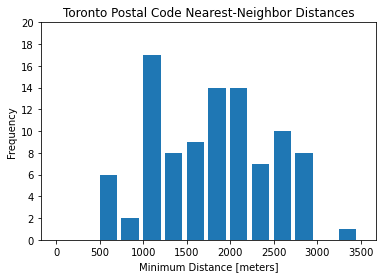

In [44]:
ax = df_h['NN Distance [m]'].plot(kind='hist', bins=np.arange(0,3750,250), width=200)
plt.yticks(np.arange(0,22,2))
plt.xlabel('Minimum Distance [meters]')
plt.title('Toronto Postal Code Nearest-Neighbor Distances');

So those close neighborhood distances had been due to zero-area postal codes.  Now neighborhoods are separated by at least 500 meters, which makes sense for a length scale for city characteristics to change between (a 5 minute walk).

Let's visualize our final dataframe for this section, sticking with the values from the HERE API lookup (in df_c), dropping the GString as it has served its purpose for validation, and keeping the nearest neighbor information as it might prove useful in the next section.

In [45]:
df_final = df_h.copy(deep=True)
df_final.drop(columns=['GString','Population','Total Dwellings','Occupied Dwellings','Square km','Population Density','Residentiality'],inplace=True)
df_final.head()

Postal Code           Borough                            Neighbourhood  \
0         M3A        North York                                Parkwoods   
1         M4A        North York                         Victoria Village   
2         M5A  Downtown Toronto                Regent Park, Harbourfront   
3         M6A        North York         Lawrence Manor, Lawrence Heights   
4         M9A         Etobicoke  Islington Avenue, Humber Valley Village   

   Latitude  Longitude  Dwelling Density  Log10 (Population Density)  \
0  43.74998  -79.32760          2.614229                    3.646166   
1  43.73064  -79.31297          2.340843                    3.485407   
2  43.65512  -79.36264          1.839341                    3.980391   
3  43.72329  -79.45099          2.606886                    3.557545   
4  43.66263  -79.52830          2.354256                    3.523958   

   Log10 (1 - Residentiality)  NN Distance [m]  NN Index  
0                   -1.358883      2179.358574        68  
1                   -1.688682      2443.750415        68  
2                   -1.115689      1115.710823        14  
3                   -1.111469      1827.071490        39  
4                   -1.410688      1734.688927        92

In [46]:
import folium

centroidlatlon = [df_final['Latitude'].mean(), df_final['Longitude'].mean()]

torontolatlon = gc.geocode("Toronto, Ontario")[1]
        
map_toronto = folium.Map(location=centroidlatlon, zoom_start=11) # generate map centred around the center of postal codes

# add a red circle marker to represent the center of neighborhoods
folium.CircleMarker(
    centroidlatlon,
    radius=10,
    color='green',
    popup='Centroid of Toronto',
    tooltip='Centroid of Toronto',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.6
).add_to(map_toronto)

folium.CircleMarker(
    torontolatlon,
    radius=15,
    color='red',
    popup='Center of Toronto',
    tooltip='Center of Toronto',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_toronto)

for i, row in df_final[['Postal Code','Latitude','Longitude']].iterrows():
    folium.CircleMarker(
        [row['Latitude'], row['Longitude']],
        radius=5,
        color='blue',
        popup=row['Postal Code'],
        tooltip=row['Postal Code'],
        fill = True,
        fill_color = 'blue',
        fill_opacity = 0.6
    ).add_to(map_toronto)

map_toronto

Finally, let's view the final dataframe.

In [47]:
showalldf(df_final)

Postal Code           Borough  \
0          M3A        North York   
1          M4A        North York   
2          M5A  Downtown Toronto   
3          M6A        North York   
4          M9A         Etobicoke   
5          M1B       Scarborough   
6          M3B        North York   
7          M4B         East York   
8          M5B  Downtown Toronto   
9          M6B        North York   
10         M9B         Etobicoke   
11         M1C       Scarborough   
12         M3C        North York   
13         M4C         East York   
14         M5C  Downtown Toronto   
15         M6C              York   
16         M9C         Etobicoke   
17         M1E       Scarborough   
18         M4E      East Toronto   
19         M5E  Downtown Toronto   
20         M6E              York   
21         M1G       Scarborough   
22         M4G         East York   
23         M5G  Downtown Toronto   
24         M6G  Downtown Toronto   
25         M1H       Scarborough   
26         M2H        North York   
27         M3H        North York   
28         M4H         East York   
29         M5H  Downtown Toronto   
30         M6H      West Toronto   
31         M1J       Scarborough   
32         M2J        North York   
33         M3J        North York   
34         M4J         East York   
35         M5J  Downtown Toronto   
36         M6J      West Toronto   
37         M1K       Scarborough   
38         M2K        North York   
39         M3K        North York   
40         M4K      East Toronto   
41         M6K      West Toronto   
42         M1L       Scarborough   
43         M2L        North York   
44         M3L        North York   
45         M4L      East Toronto   
46         M6L        North York   
47         M9L        North York   
48         M1M       Scarborough   
49         M2M        North York   
50         M3M        North York   
51         M4M      East Toronto   
52         M5M        North York   
53         M6M              York   
54         M9M        North York   
55         M1N       Scarborough   
56         M2N        North York   
57         M3N        North York   
58         M4N   Central Toronto   
59         M5N   Central Toronto   
60         M6N              York   
61         M9N              York   
62         M1P       Scarborough   
63         M2P        North York   
64         M4P   Central Toronto   
65         M5P   Central Toronto   
66         M6P      West Toronto   
67         M9P         Etobicoke   
68         M1R       Scarborough   
69         M2R        North York   
70         M4R   Central Toronto   
71         M5R   Central Toronto   
72         M6R      West Toronto   
73         M9R         Etobicoke   
74         M1S       Scarborough   
75         M4S   Central Toronto   
76         M5S  Downtown Toronto   
77         M6S      West Toronto   
78         M1T       Scarborough   
79         M4T   Central Toronto   
80         M5T  Downtown Toronto   
81         M1V       Scarborough   
82         M4V   Central Toronto   
83         M5V  Downtown Toronto   
84         M8V         Etobicoke   
85         M9V         Etobicoke   
86         M1W       Scarborough   
87         M4W  Downtown Toronto   
88         M8W         Etobicoke   
89         M9W         Etobicoke   
90         M1X       Scarborough   
91         M4X  Downtown Toronto   
92         M8X         Etobicoke   
93         M4Y  Downtown Toronto   
94         M8Y         Etobicoke   
95         M8Z         Etobicoke   

                                        Neighbourhood  Latitude  Longitude  \
0                                           Parkwoods  43.74998  -79.32760   
1                                    Victoria Village  43.73064  -79.31297   
2                           Regent Park, Harbourfront  43.65512  -79.36264   
3                    Lawrence Manor, Lawrence Heights  43.72329  -79.45099   
4             Islington Avenue, Humber Valley Village  43.66263  -79.52830   
5                                      Mal

## Venue Discovery and Feature Generation

We begin by loading Foursquare credentials and defining variables necessary for our queries.

In [48]:
import config

import importlib
importlib.reload(config)

CLIENT_ID = config.FOURSQUARE_CLIENT_ID
CLIENT_SECRET = config.FOURSQUARE_CLIENT_SECRET
ACCESS_TOKEN = config.FOURSQUARE_ACCESS_TOKEN
VERSION = '20180604'
LIMIT = 100
RADIUS = 500

We now define some utility functions for data acquisition and plotting.

In [49]:
import requests

# Queries a location to find nearby venues, uses session variables CLIENT_ID, CLIENT_SECRET, VERSION, LIMIT
def FoursquareExplore(latitude, longitude, radius):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    results = requests.get(url).json()
    if results['response']=={}:
        if results['meta']['errorDetail']=='Quota exceeded':
            print('Foursquare quota exceeded, please try again later')
        else:
            print('No results returned')
        print(results)
    items = results['response']['groups'][0]['items']
    if len(items)>0:
        dataframe = pd.json_normalize(items)
        filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
        dataframe_filtered = dataframe.loc[:, filtered_columns]
        dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]
        return dataframe_filtered
    else:
        return None

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def getNearbyVenues(df_in, radius=500, extend=True):
    venues_df = pd.DataFrame(columns=['Postal Code','Venue Name','Venue Latitude','Venue Longitude','Venue Category','Radius'])
    for i, row in df_in.iterrows():
        # Get the neaby venues
        rad = radius
        df = FoursquareExplore(row['Latitude'],row['Longitude'],rad)
        print(row['Postal Code'])
        print(row['Postal Code'], f"radius {rad}", f"entries {df.shape[0] if not df is None else 0}")
        if extend:
            while (df is None or df.shape[0]<LIMIT/2) and rad<=max(radius,row['NN Distance [m]']/2):
                rad = rad+radius/2
                df = FoursquareExplore(row['Latitude'],row['Longitude'],rad)
                print(row['Postal Code'], f"radius {rad}", f"entries {df.shape[0] if not df is None else 0}")
        # Shorten the dataframe
        if not df is None:
            df_add = pd.DataFrame([[row['Postal Code'],r['name'],r['lat'],r['lng'],get_category_type(r),rad] for _, r in df.iterrows()], columns=venues_df.columns)
            venues_df = venues_df.append(df_add,ignore_index=True)
    return(venues_df)

def resumableGetNearbyVenues(df_in,df_venues=None,radius=500,extend=True):
    # Can be called with partial results in df_venues, and will resume populating it until another quota error from Foursquare
    # df_venues is populated only after satisfying query conditions (may need multiple calls if extend=True)
    # Need to deal with indexing - .loc uses dataframe indexes which are not necessarily zero-based 1-increment
    # TODO: Change selection method to evaluate indices only when they are not found in df_venues, this could also handle change of order
    if df_venues is None or df_venues.shape[0]==0:
        df_venues = pd.DataFrame(columns=['Postal Code','Venue Name','Venue Latitude','Venue Longitude','Venue Category','Radius'])
        current_index = 0
    else:
        last_postal_code = df_venues['Postal Code'][df_venues.shape[0]-1]
        current_index = np.asarray(df_in['Postal Code']==last_postal_code).nonzero()[0][0]+1
        # TODO: handle case where a complete df_venues is provided, though this should not occur because isComplete is returned
    
    isComplete = current_index == (df_in.shape[0])
    for index in range(current_index,df_in.shape[0]):
        try:
            df_add = getNearbyVenues(df_in.iloc[[index],:],radius=radius,extend=extend)
            df_venues = df_venues.append(df_add, ignore_index=True)
            isComplete = index == (df_in.shape[0]-1)
        except KeyError:
            isComplete = False
            print('Error encountered in venue lookup')
            break

    return isComplete, df_venues

We can now get nearby venues for each postal code.  The Radius entry is the radius (in meters) that is required for the Foursquare API to return at least LIMIT/2 (50) venues.  Radius is increased in increments of half the input radius until LIMIT/2 venues are returned if the extend parameter is True.

In [50]:
fn_venues = 'df_venues_archived.db'
venues_loaded = False
try:
    with open(fn_venues,'rb') as f:
        (isComplete, df_venues) = dill.loads(f.read())
    venues_loaded = True
    print('Venues loaded from file')
except (FileNotFoundError, IOError) as e:
    print(f'ERROR on file read: {e}')
    print('Polling new venue list...')
    isComplete, df_venues = resumableGetNearbyVenues(df_final, None, radius=RADIUS, extend=True)
    print('Venue lookup completed successfully' if isComplete else 'Venue lookup interrupted, try repeated execution of next cell')

display(df_venues.head())

if not (isComplete and venues_loaded):
    path = os.path.dirname(fn_venues)
    if path!='':
        os.makedirs(path, exist_ok=True)
    try:
        with open(fn_venues,'wb+') as file:
            file.write(dill.dumps((isComplete, df_venues)))
            print('Venue saving completed successfully')
    except IOError as e:
        print(f'ERROR on file write: {e}')

Venues loaded from file


Postal Code          Venue Name  Venue Latitude  Venue Longitude  \
0         M3A     Allwyn's Bakery       43.759840       -79.324719   
1         M3A     Brookbanks Park       43.751976       -79.332140   
2         M3A   Bruno's valu-mart       43.746143       -79.324630   
3         M3A         Tim Hortons       43.760668       -79.326368   
4         M3A  Shoppers Drug Mart       43.745315       -79.325800   

         Venue Category  Radius                     Category Parents  \
0  Caribbean Restaurant  1250.0                               [Food]   
1                  Park  1250.0              [Outdoors & Recreation]   
2         Grocery Store  1250.0  [Shop & Service, Food & Drink Shop]   
3                  Café  1250.0                               [Food]   
4              Pharmacy  1250.0                     [Shop & Service]   

   Category Depth  
0               1  
1               1  
2               2  
3               1  
4               1

If the lookup fails due to quotas (or presumably timeout), the following cell can be run multiple times until successful completion (e.g. on multiple days should operation be interrupted due to exceeding quotas).

In [51]:
isComplete=False

In [52]:
if not isComplete:
    isComplete, df_venues = resumableGetNearbyVenues(df_final, df_venues, radius=RADIUS, extend=True)
    print('Venue lookup completed successfully' if isComplete else 'Venue lookup interrupted, execute this cell again after appropriate delay')
    path = os.path.dirname(fn_venues)
    if path!='':
        os.makedirs(path, exist_ok=True)
    try:
        with open(fn_venues,'wb+') as file:
            file.write(dill.dumps((isComplete, df_venues)))
            print('Venue saving completed successfully')
    except IOError as e:
        print(f'ERROR on file write: {e}')
    display(df_venues)
else:
    print('Venue lookup is already finished')

Venue lookup completed successfully
Venue saving completed successfully


Postal Code                                  Venue Name  Venue Latitude  \
0            M3A                             Allwyn's Bakery       43.759840   
1            M3A                             Brookbanks Park       43.751976   
2            M3A                           Bruno's valu-mart       43.746143   
3            M3A                                 Tim Hortons       43.760668   
4            M3A                          Shoppers Drug Mart       43.745315   
...          ...                                         ...             ...   
4064         M8Z                              Appalachia BBQ       43.624034   
4065         M8Z  Light Up The Floor - Your Lifestyle Studio       43.635114   
4066         M8Z                                      Cora's       43.617940   
4067         M8Z                                    Goodwill       43.621602   
4068         M8Z                    Performance Improvements       43.635205   

      Venue Longitude          Venue Category  Radius  \
0          -79.324719    Caribbean Restaurant  1250.0   
1          -79.332140                    Park  1250.0   
2          -79.324630           Grocery Store  1250.0   
3          -79.326368                    Café  1250.0   
4          -79.325800                Pharmacy  1250.0   
...               ...                     ...     ...   
4064       -79.514079               BBQ Joint  1250.0   
4065       -79.523928    Gym / Fitness Center  1250.0   
4066       -79.538750          Breakfast Spot  1250.0   
4067       -79.513198  Thrift / Vintage Store  1250.0   
4068       -79.521983         Automotive Shop  1250.0   

                                 Category Parents  Category Depth  
0                                          [Food]               1  
1                         [Outdoors & Recreation]               1  
2             [Shop & Service, Food & Drink Shop]               2  
3                                          [Food]               1  
4                                [Shop & Service]               1  
...                                           ...             ...  
4064                                       [Food]               1  
4065  [Outdoors & Recreation, Athletics & Sports]               2  
4066                                       [Food]               1  
4067                             [Shop & Service]               1  
4068                             [Shop & Service]               1  

[4069 rows x 8 columns]

Let's make sure we have some features for every location:

In [53]:
missing_postal_codes = list(np.setdiff1d(df_final['Postal Code'],df_venues['Postal Code']))
print(f"There are {len(missing_postal_codes)} postal codes with no venues: {missing_postal_codes}")
print(f"There are {len(df_venues['Venue Category'].unique())} unique categories among {df_venues.shape[0]} venues (ratio of 1 to {df_venues.shape[0]/len(df_venues['Venue Category'].unique()):.1f}).")

There are 0 postal codes with no venues: []
There are 334 unique categories among 4069 venues (ratio of 1 to 12.2).


Let's see the distribution of number of venues found in each postal code:

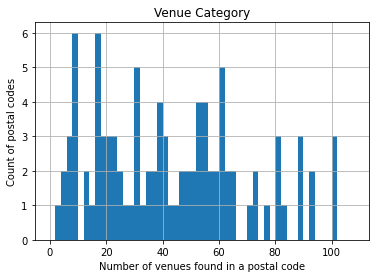

In [54]:
df_venue_counts = df_venues[['Postal Code','Venue Category']].groupby('Postal Code').count()
df_venue_counts.hist(bins=np.arange(0,110,2))
plt.xlabel('Number of venues found in a postal code')
plt.ylabel('Count of postal codes');

And the distribution of frequency of venue type across all of Toronto:

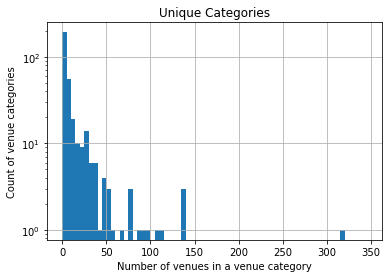

In [55]:
df_category_counts = df_venues[['Postal Code','Venue Category']].groupby('Venue Category').count()
df_category_counts.rename(columns={'Postal Code':'Unique Categories'},inplace=True)
df_category_counts.hist(bins=np.arange(0,350,5),log=True)
plt.xlabel('Number of venues in a venue category')
plt.ylabel('Count of venue categories');

Now it seems there is a [heirarchy of categories](https://developer.foursquare.com/docs/build-with-foursquare/categories/) and we might do well to restrict ourselves to higher level categories.  Let's get the category data structure:

In [56]:
try:
    categories_list = requests.get(f"https://api.foursquare.com/v2/venues/categories?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}").json()
    categories_list = categories_list['response']['categories']
    print('Categories retrieved')
except KeyError:
    print('There was an error getting categories from Foursquare')

Categories retrieved


In [57]:
def findParentCategories(categories_list,categories_dict={},parents=[]):
    # Recursively explore categories_list, and modify categories_dict, where the keys are the categroies and values are lists of parents, highest first. 
    for c in categories_list:
        categories_dict[c['name']] = parents
        if len(c['categories'])==0: # Leaf condition
            categories_dict[c['name']] = parents
        else: # Branch condition
            findParentCategories(c['categories'],categories_dict,[*parents, c['name']])

def getCategoriesByDepth(categories_dict,depth=0):
    # Returns a dict of all categories at the given depth (with parent list for values)
    ret = {}
    for key, val in categories_dict.items():
        if len(val)==depth:
            ret[key] = val
    return ret

def getCategoryDepth(categories_dict,category):
    # Returns the integer dpeth of category in categories_dict
    return len(categories_dict['category'])

In [58]:
categories_dict = {}
findParentCategories(categories_list,categories_dict)
print(f"There are {len(categories_dict)} unique category labels.")

There are 971 unique category labels.


And we can examine how many labels are at each level of the hierarchy:

In [59]:
category_count = []
categories_depth_list = []
while sum(category_count)<len(categories_dict):
    categories_depth_list.append(getCategoriesByDepth(categories_dict,len(category_count)))
    category_count.append(len(categories_depth_list[-1]))
    print(f"There are {category_count[-1]} categories at depth {len(category_count)-1}.")

There are 10 categories at depth 0.
There are 470 categories at depth 1.
There are 383 categories at depth 2.
There are 94 categories at depth 3.
There are 14 categories at depth 4.


This can quickly find the sum of branch and leaf categories at each depth in our data:

In [60]:
df_venues['Category Parents'] = [categories_dict[row['Venue Category']] for _, row in df_venues.iterrows()]
df_venues['Category Depth'] = df_venues['Category Parents'].apply(len)
display(df_venues.head(3))

for k in np.sort(df_venues['Category Depth'].unique()):
    colname = f"Venue Category, Depth {k}"
    print(f"At depth {k} there are {sum(df_venues['Category Depth']==k)} venue category entries.")

Postal Code         Venue Name  Venue Latitude  Venue Longitude  \
0         M3A    Allwyn's Bakery       43.759840       -79.324719   
1         M3A    Brookbanks Park       43.751976       -79.332140   
2         M3A  Bruno's valu-mart       43.746143       -79.324630   

         Venue Category  Radius                     Category Parents  \
0  Caribbean Restaurant  1250.0                               [Food]   
1                  Park  1250.0              [Outdoors & Recreation]   
2         Grocery Store  1250.0  [Shop & Service, Food & Drink Shop]   

   Category Depth  
0               1  
1               1  
2               2

At depth 0 there are 2 venue category entries.
At depth 1 there are 3042 venue category entries.
At depth 2 there are 864 venue category entries.
At depth 3 there are 160 venue category entries.
At depth 4 there are 1 venue category entries.


Alternatively, we can examine explicitly how many labels are leaf or branch nodes for all potential categories:

In [61]:
leaf_list = []
node_list = []
for k in range(len(categories_depth_list)):
    leaf_list.append([])
    node_list.append([])

for key, val in categories_dict.items(): # Go through the dict; if a key appears in a value, it is a branch, if it never appears in a value (as a parent), it is a leaf
    node = False
    for k, v in categories_dict.items():
        if key==k:
            pass
        elif key in v: # Key appears as a parent
            node_list[len(val)].append(key)
            node=True
            break
    if not node: # Key did not appear as a parent - it is a leaf
        leaf_list[len(val)].append(key)

for k in range(len(leaf_list)):
    print(f"At depth {k} there are {len(node_list[k])} branches and {len(leaf_list[k])} leaves.")

At depth 0 there are 10 branches and 0 leaves.
At depth 1 there are 53 branches and 417 leaves.
At depth 2 there are 10 branches and 373 leaves.
At depth 3 there are 2 branches and 92 leaves.
At depth 4 there are 0 branches and 14 leaves.


And then discover whether the Toronto venue data categories occur at branch or leaf nodes:

In [62]:
leaf_toronto = [[] for k in range(len(leaf_list))]
node_toronto = [[] for k in range(len(node_list))]

for cat in df_venues['Venue Category']:
    for k in range(len(leaf_list)):
        if cat in leaf_list[k]:
            leaf_toronto[k].append(cat)
        if cat in node_list[k]:
            node_toronto[k].append(cat)

for k in range(len(leaf_toronto)):
    print(f"At depth {k} there are {len(node_toronto[k])} categories that are branches and {len(leaf_toronto[k])} categories that are leaves.")

At depth 0 there are 2 categories that are branches and 0 categories that are leaves.
At depth 1 there are 633 categories that are branches and 2409 categories that are leaves.
At depth 2 there are 225 categories that are branches and 639 categories that are leaves.
At depth 3 there are 2 categories that are branches and 158 categories that are leaves.
At depth 4 there are 0 categories that are branches and 1 categories that are leaves.


### Venue Feature Creation

We can create one-hots both for leaf and node categories and to assign more weight in the clustering to lower depth nodes (to emphasize matching broader categories first, but this may get needlessly complex.  We can generate the additional one-hot dataframes just in case, but then continue with the simpler analysis first.

Note that this could be done by limiting different parent categories to different depths of children, but that is too complex for now.

Note also that it would be reasonable to compact some venues (like zoo exhibits) into one entry in order to not overemphasize certain venues (like zoos), but this is also a bit beyond the current complexity level.

In [63]:
df_venues.head()

Postal Code          Venue Name  Venue Latitude  Venue Longitude  \
0         M3A     Allwyn's Bakery       43.759840       -79.324719   
1         M3A     Brookbanks Park       43.751976       -79.332140   
2         M3A   Bruno's valu-mart       43.746143       -79.324630   
3         M3A         Tim Hortons       43.760668       -79.326368   
4         M3A  Shoppers Drug Mart       43.745315       -79.325800   

         Venue Category  Radius                     Category Parents  \
0  Caribbean Restaurant  1250.0                               [Food]   
1                  Park  1250.0              [Outdoors & Recreation]   
2         Grocery Store  1250.0  [Shop & Service, Food & Drink Shop]   
3                  Café  1250.0                               [Food]   
4              Pharmacy  1250.0                     [Shop & Service]   

   Category Depth  
0               1  
1               1  
2               2  
3               1  
4               1

In [64]:
for k in range(df_venues['Category Depth'].max()+1):
    df_venues[f"Venue Category, Depth {k}"] = [row['Venue Category'] if row['Category Depth']<=k else row['Category Parents'][k] for _, row in df_venues.iterrows()]
df_venues.head()

Postal Code          Venue Name  Venue Latitude  Venue Longitude  \
0         M3A     Allwyn's Bakery       43.759840       -79.324719   
1         M3A     Brookbanks Park       43.751976       -79.332140   
2         M3A   Bruno's valu-mart       43.746143       -79.324630   
3         M3A         Tim Hortons       43.760668       -79.326368   
4         M3A  Shoppers Drug Mart       43.745315       -79.325800   

         Venue Category  Radius                     Category Parents  \
0  Caribbean Restaurant  1250.0                               [Food]   
1                  Park  1250.0              [Outdoors & Recreation]   
2         Grocery Store  1250.0  [Shop & Service, Food & Drink Shop]   
3                  Café  1250.0                               [Food]   
4              Pharmacy  1250.0                     [Shop & Service]   

   Category Depth Venue Category, Depth 0 Venue Category, Depth 1  \
0               1                    Food    Caribbean Restaurant   
1               1   Outdoors & Recreation                    Park   
2               2          Shop & Service       Food & Drink Shop   
3               1                    Food                    Café   
4               1          Shop & Service                Pharmacy   

  Venue Category, Depth 2 Venue Category, Depth 3 Venue Category, Depth 4  
0    Caribbean Restaurant    Caribbean Restaurant    Caribbean Restaurant  
1                    Park                    Park                    Park  
2           Grocery Store           Grocery Store           Grocery Store  
3                    Café                    Café                    Café  
4                Pharmacy                Pharmacy                Pharmacy

It may be useful to know how many categories we have to deal with at each depth:

In [65]:
for k in np.sort(df_venues['Category Depth'].unique()):
    colname = f"Venue Category, Depth {k}"
    print(f"There are {len(df_venues[colname].unique())} unique categories limited to depth {k}")

There are 9 unique categories limited to depth 0
There are 224 unique categories limited to depth 1
There are 311 unique categories limited to depth 2
There are 333 unique categories limited to depth 3
There are 334 unique categories limited to depth 4


From all this we expect that most the optimal category depth will be 1 or 2; depth 0 is quite general, while depth above 2 becomes too specific and adds little additional information (no information in the case of depth 4).

Note that the columns 'Venue Category' and 'Venue Category, Depth 4' are equivalent.

In [66]:
all(df_venues['Venue Category']==df_venues['Venue Category, Depth 4'])

True

#### Create a venue vector for each neighborhood

In [67]:
def makeOneHot(df,colname,keycolname):
    # Returns (onehot of df[colname] with first column df[keycolname],
    #          df with leading column df[keycolname].unique() and rows the normalized venue frequency vector and columns the venue category
    onehot = pd.get_dummies(df[[colname]], prefix="", prefix_sep="")
    onehot[keycolname] = df[keycolname]
    onehot = onehot[[onehot.columns[-1]] + list(onehot.columns[:-1])]
    grouped = onehot.groupby(keycolname).mean().reset_index()
    return onehot, grouped

In [68]:
# Basic one-hot encoding
toronto_onehot, toronto_grouped = makeOneHot(df_venues,'Venue Category','Postal Code')

# Create columns to hold venues limited to a given depth
toronto_onehot_0, toronto_grouped_0 = makeOneHot(df_venues,'Venue Category, Depth 0','Postal Code')
toronto_onehot_1, toronto_grouped_1 = makeOneHot(df_venues,'Venue Category, Depth 1','Postal Code')
toronto_onehot_2, toronto_grouped_2 = makeOneHot(df_venues,'Venue Category, Depth 2','Postal Code')
toronto_onehot_3, toronto_grouped_3 = makeOneHot(df_venues,'Venue Category, Depth 3','Postal Code')
toronto_onehot_4, toronto_grouped_4 = makeOneHot(df_venues,'Venue Category, Depth 4','Postal Code')

print()
print('Full Depth category coding:')
print()
display(toronto_onehot.head())
print(f"Shape of Full Depth category coding: {toronto_onehot.shape}")
print()
display(toronto_grouped.head())
print(f"Shape of Full Depth category coding, grouped by Postal Code: {toronto_grouped.shape}")
print()

print()
print('Depth 0 category coding:')
print()
display(toronto_onehot_0.head())
print(f"Shape of Depth 0 category coding: {toronto_onehot_0.shape}")
print()
display(toronto_grouped_0.head())
print(f"Shape of Depth 0 category coding, grouped by Postal Code: {toronto_grouped_0.shape}")


Full Depth category coding:



Postal Code  ATM  Adult Boutique  Afghan Restaurant  African Restaurant  \
0         M3A    0               0                  0                   0   
1         M3A    0               0                  0                   0   
2         M3A    0               0                  0                   0   
3         M3A    0               0                  0                   0   
4         M3A    0               0                  0                   0   

   Airport  American Restaurant  Animal Shelter  Antique Shop  Aquarium  ...  \
0        0                    0               0             0         0  ...   
1        0                    0               0             0         0  ...   
2        0                    0               0             0         0  ...   
3        0                    0               0             0         0  ...   
4        0                    0               0             0         0  ...   

   Vietnamese Restaurant  Volleyball Court  Warehouse Store  Waste Facility  \
0                      0                 0                0               0   
1                      0                 0                0               0   
2                      0                 0                0               0   
3                      0                 0                0               0   
4                      0                 0                0               0   

   Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  Zoo Exhibit  
0         0          0            0              0            0            0  
1         0          0            0              0            0            0  
2         0          0            0              0            0            0  
3         0          0            0              0            0            0  
4         0          0            0              0            0            0  

[5 rows x 335 columns]

Shape of Full Depth category coding: (4069, 335)



Postal Code  ATM  Adult Boutique  Afghan Restaurant  African Restaurant  \
0         M1B  0.0             0.0                0.0                 0.0   
1         M1C  0.0             0.0                0.0                 0.0   
2         M1E  0.0             0.0                0.0                 0.0   
3         M1G  0.0             0.0                0.0                 0.0   
4         M1H  0.0             0.0                0.0                 0.0   

   Airport  American Restaurant  Animal Shelter  Antique Shop  Aquarium  ...  \
0      0.0                  0.0             0.0           0.0       0.0  ...   
1      0.0                  0.0             0.0           0.0       0.0  ...   
2      0.0                  0.0             0.0           0.0       0.0  ...   
3      0.0                  0.0             0.0           0.0       0.0  ...   
4      0.0                  0.0             0.0           0.0       0.0  ...   

   Vietnamese Restaurant  Volleyball Court  Warehouse Store  Waste Facility  \
0                    0.0               0.0              0.0             0.0   
1                    0.0               0.0              0.0             0.0   
2                    0.0               0.0              0.0             0.0   
3                    0.0               0.0              0.0             0.0   
4                    0.0               0.0              0.0             0.0   

   Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  Zoo Exhibit  
0       0.0        0.0          0.0            0.0          0.0     0.451613  
1       0.0        0.0          0.0            0.0          0.0     0.000000  
2       0.0        0.0          0.0            0.0          0.0     0.000000  
3       0.0        0.0          0.0            0.0          0.0     0.000000  
4       0.0        0.0          0.0            0.0          0.0     0.000000  

[5 rows x 335 columns]

Shape of Full Depth category coding, grouped by Postal Code: (96, 335)


Depth 0 category coding:



Postal Code  Arts & Entertainment  College & University  Food  \
0         M3A                     0                     0     1   
1         M3A                     0                     0     0   
2         M3A                     0                     0     0   
3         M3A                     0                     0     1   
4         M3A                     0                     0     0   

   Nightlife Spot  Outdoors & Recreation  Professional & Other Places  \
0               0                      0                            0   
1               0                      1                            0   
2               0                      0                            0   
3               0                      0                            0   
4               0                      0                            0   

   Residence  Shop & Service  Travel & Transport  
0          0               0                   0  
1          0               0                   0  
2          0               1                   0  
3          0               0                   0  
4          0               1                   0

Shape of Depth 0 category coding: (4069, 10)



Postal Code  Arts & Entertainment  College & University      Food  \
0         M1B              0.451613                   0.0  0.193548   
1         M1C              0.000000                   0.0  0.384615   
2         M1E              0.000000                   0.0  0.448980   
3         M1G              0.000000                   0.0  0.555556   
4         M1H              0.000000                   0.0  0.652174   

   Nightlife Spot  Outdoors & Recreation  Professional & Other Places  \
0        0.000000               0.161290                     0.000000   
1        0.000000               0.461538                     0.000000   
2        0.040816               0.122449                     0.020408   
3        0.000000               0.222222                     0.000000   
4        0.000000               0.086957                     0.000000   

   Residence  Shop & Service  Travel & Transport  
0        0.0        0.193548            0.000000  
1        0.0        0.153846            0.000000  
2        0.0        0.306122            0.061224  
3        0.0        0.222222            0.000000  
4        0.0        0.217391            0.043478

Shape of Depth 0 category coding, grouped by Postal Code: (96, 10)


It may be interesting to examine the venues occurring at highest frequency in each postal code.  We do so below, but note that this is not used in feature generation in favor of the grouped onehot vectors.  Using features created only from the highest frequency venue categories would be an interesting approach to try (some other time).

In [69]:
def printNeighborhoodVenueFrequency(df_tmp, key_col_name='Postal Code', num_top_venues=5):
    for hood in df_tmp[key_col_name]:
        neighborhoods_str = ''
        for n in df_final.loc[df_final['Postal Code']==hood,'Neighbourhood']:
            neighborhoods_str += n
        print("----"+hood+": "+neighborhoods_str+"----")
        temp = df_tmp[df_tmp[key_col_name] == hood].T.reset_index()
        temp.columns = ['venue','freq']
        temp = temp.iloc[1:]
        temp['freq'] = temp['freq'].astype(float)
        temp = temp.round({'freq': 2})
        print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
        print('\n')

In [70]:
printNeighborhoodVenueFrequency(toronto_grouped,'Postal Code',5)

----M1B: Malvern, Rouge----
                  venue  freq
0           Zoo Exhibit  0.45
1  Fast Food Restaurant  0.06
2                 Trail  0.06
3            Hobby Shop  0.03
4            Restaurant  0.03


----M1C: Rouge Hill, Port Union, Highland Creek----
                venue  freq
0                Park  0.15
1  Italian Restaurant  0.08
2          Playground  0.08
3        Neighborhood  0.08
4      Breakfast Spot  0.08


----M1E: Guildwood, Morningside, West Hill----
               venue  freq
0        Pizza Place  0.08
1               Park  0.06
2         Restaurant  0.06
3     Breakfast Spot  0.06
4  Electronics Store  0.04


----M1G: Woburn----
                  venue  freq
0                  Park  0.22
1           Coffee Shop  0.22
2              Pharmacy  0.11
3             Juice Bar  0.11
4  Fast Food Restaurant  0.11


----M1H: Cedarbrae----
               venue  freq
0  Indian Restaurant  0.17
1        Coffee Shop  0.09
2       Burger Joint  0.04
3         Playground  0.

In [71]:
printNeighborhoodVenueFrequency(toronto_grouped_0,'Postal Code',5)

----M1B: Malvern, Rouge----
                   venue  freq
0   Arts & Entertainment  0.45
1                   Food  0.19
2         Shop & Service  0.19
3  Outdoors & Recreation  0.16
4   College & University  0.00


----M1C: Rouge Hill, Port Union, Highland Creek----
                   venue  freq
0  Outdoors & Recreation  0.46
1                   Food  0.38
2         Shop & Service  0.15
3   Arts & Entertainment  0.00
4   College & University  0.00


----M1E: Guildwood, Morningside, West Hill----
                   venue  freq
0                   Food  0.45
1         Shop & Service  0.31
2  Outdoors & Recreation  0.12
3     Travel & Transport  0.06
4         Nightlife Spot  0.04


----M1G: Woburn----
                   venue  freq
0                   Food  0.56
1  Outdoors & Recreation  0.22
2         Shop & Service  0.22
3   Arts & Entertainment  0.00
4   College & University  0.00


----M1H: Cedarbrae----
                   venue  freq
0                   Food  0.65
1         Shop &

In [72]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [73]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postal Code'] = toronto_grouped['Postal Code']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Postal Code 1st Most Common Venue 2nd Most Common Venue  \
0         M1B           Zoo Exhibit  Fast Food Restaurant   
1         M1C                  Park    Italian Restaurant   
2         M1E           Pizza Place                  Park   
3         M1G                  Park           Coffee Shop   
4         M1H     Indian Restaurant           Coffee Shop   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                 Trail            Hobby Shop            Restaurant   
1            Playground          Neighborhood        Breakfast Spot   
2            Restaurant        Breakfast Spot     Electronics Store   
3              Pharmacy             Juice Bar  Fast Food Restaurant   
4          Burger Joint            Playground              Bus Line   

  6th Most Common Venue 7th Most Common Venue          8th Most Common Venue  \
0           Coffee Shop                  Park  Paper / Office Supplies Store   
1                   Gym  Gym / Fitness Center                       Pharmacy   
2  Fast Food Restaurant                 Hotel                           Bank   
3     Mobile Phone Shop    Chinese Restaurant                            ATM   
4           Music Store     German Restaurant            Fried Chicken Joint   

  9th Most Common Venue         10th Most Common Venue  
0  Caribbean Restaurant                            Spa  
1           Pizza Place                           Bank  
2    Chinese Restaurant         Thrift / Vintage Store  
3     Other Repair Shop  Paper / Office Supplies Store  
4  Caribbean Restaurant             Chinese Restaurant

Returning to feature generation, it might be useful to include the overall areal density of venues as a feature.  This can be done using the radius that was required to get the target number of venues returned when we listed the venues in each postal code.  This method is imperfect because of the results massaging done by Foursquare, but is the best we can do with that data source.

Venue density varies from 0.849 to 127.324 with mean 24.428 and standard deviation 31.488


Postal Code  Venue Radius  Venue Count  Venue Density  Log10 (Venue Density)
0         M1B        1500.0           31       4.385603               0.642029
1         M1C        1500.0           13       1.839124               0.264611
2         M1E        1500.0           49       6.932082               0.840864
3         M1G        1000.0            9       2.864789               0.457093
4         M1H        1000.0           23       7.321127               0.864578

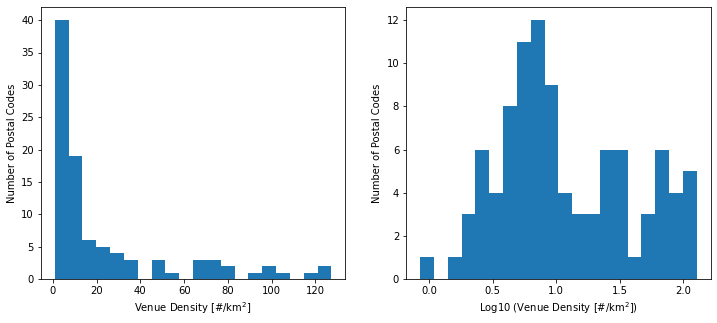

In [74]:
df_venue_density = df_venues[['Postal Code','Radius']].groupby('Postal Code').mean(numeric_only=False).reset_index().rename(columns={'Radius':'Venue Radius'})
df_venue_density = df_venue_density.merge(df_venues[['Postal Code','Radius']].groupby('Postal Code').count().reset_index().rename(columns={'Radius':'Venue Count'}),on='Postal Code')
df_venue_density['Venue Density'] = df_venue_density['Venue Count']/(np.pi*(df_venue_density['Venue Radius']/1000)**2)
df_venue_density['Log10 (Venue Density)'] = df_venue_density['Venue Density'].apply(np.log10)

print(f"Venue density varies from {min(df_venue_density['Venue Density']):.3f} to {max(df_venue_density['Venue Density']):.3f} with mean {np.mean(df_venue_density['Venue Density']):.3f} and standard deviation {np.std(df_venue_density['Venue Density']):.3f}")

display(df_venue_density.head())

fig, axs = plt.subplots(1,2,figsize=(12,5))
ax = axs[0]
ax.hist(x=df_venue_density['Venue Density'],bins=20,log=False)
ax.set_xlabel('Venue Density [#/km$^2$]')
ax.set_ylabel('Number of Postal Codes')
ax = axs[1]
ax.hist(x=df_venue_density['Log10 (Venue Density)'],bins=20,log=False)
ax.set_xlabel('Log10 (Venue Density [#/km$^2$])')
ax.set_ylabel('Number of Postal Codes');

The distribution of the logarithm of venue density looks more normal and therefore is expected to be better suited as a feature for clustering, so we will use that below.

Here we construct a list of inputs to our clustering algorithm, with the most relevant entry being various feature sets it will be interesting to fit to, including:
* Venue data only
* Census data and venue density data only
* Combined venue and census/venue density data
* Alternative preprocessing (scaling)

Note that giving different scale factors to various features might result in improved fits - this might be worth exploring in a future work.

In [75]:
k_means_data = []
POSTAL_CODES = toronto_grouped

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
scaler = MinMaxScaler() # StandardScaler(), RobustScaler(), MinMaxScaler(), QuantileTransformer(output_distribution='normal', random_state=0)

# Order:
#  0- 4: Venues, no scaling
#  5- 9: Venues, Census, VDensity, scaled
# 10-14: Venues, Census, VDensity, scaled with additional Venues factor
#    15: Census data, scaled
#    16: Venue density, scaled
#    17: Census data and Venue density, scaled

# Add entries for Venues at various category depths
for i in range(max(df_venues['Category Depth'])+1):
    features = locals()[f"toronto_grouped_{i}"]
    add_dict = {'name':f"Venues Depth {i}",
                'labels':features['Postal Code'],
                'features':features.drop(columns='Postal Code')
               }
    k_means_data.append(add_dict)
'''
# Duplicate the above and add the census features from df_final
for i in range(max(df_venues['Category Depth'])+1):
    features = locals()[f"toronto_grouped_{i}"].merge(df_final[['Postal Code','Dwelling Density','Log10 (Population Density)','Log10 (1 - Residentiality)']],on='Postal Code')
    add_dict = {'name':f"Venues Depth {i} with Census Data",
                'labels':features['Postal Code'],
                'features':features.drop('Postal Code',1)
               }
    k_means_data.append(add_dict)

# Duplicate the above and add the Foursquare venue density
for i in range(max(df_venues['Category Depth'])+1):
    features = locals()[f"toronto_grouped_{i}"].merge(df_final[['Postal Code','Dwelling Density','Log10 (Population Density)','Log10 (1 - Residentiality)']],on='Postal Code').merge(df_venue_density[['Postal Code','Log10 (Venue Density)']],on='Postal Code')
    add_dict = {'name':f"Venues Depth {i} with Census Data and Venue Density",
                'labels':features['Postal Code'],
                'features':features.drop('Postal Code',1)
               }
    k_means_data.append(add_dict)

# Duplicate the above but also normalize the non-venue-vector features
scale_column_names = ['Dwelling Density','Log10 (Population Density)','Log10 (1 - Residentiality)','Log10 (Venue Density)']
for i in range(max(df_venues['Category Depth'])+1):
    features = locals()[f"toronto_grouped_{i}"].merge(df_final[['Postal Code','Dwelling Density','Log10 (Population Density)','Log10 (1 - Residentiality)']],on='Postal Code').merge(df_venue_density[['Postal Code','Log10 (Venue Density)']],on='Postal Code')
    add_dict = {'name':f"Venues Depth {i} with scaled Census Data and Venue Density",
                'labels':features['Postal Code'],
                'features':features.drop('Postal Code',1)
               }
    add_dict['features'][scale_column_names] = scaler.fit_transform(add_dict['features'][scale_column_names])
    k_means_data.append(add_dict)
'''
# Venues scaled globally, Census data and Venue density scaled
scale_column_names = ['Dwelling Density','Log10 (Population Density)','Log10 (1 - Residentiality)','Log10 (Venue Density)']
for i in range(max(df_venues['Category Depth'])+1):
    features = locals()[f"toronto_grouped_{i}"]
    vectors = features.drop(columns='Postal Code').values
    vectors = scaler.fit_transform(vectors.reshape(-1,1)).reshape(*list(vectors.shape))
    vectors = vectors
    features[features.columns.drop('Postal Code')] = vectors
    features = features.merge(df_final[['Postal Code','Dwelling Density','Log10 (Population Density)','Log10 (1 - Residentiality)']],on='Postal Code').merge(df_venue_density[['Postal Code','Log10 (Venue Density)']],on='Postal Code')
    add_dict = {'name':f"Scaled Venues Depth {i}\n with scaled Census Data\n and Venue Density",
                'labels':features['Postal Code'],
                'features':features.drop(columns='Postal Code')
               }
    add_dict['features'][scale_column_names] = scaler.fit_transform(add_dict['features'][scale_column_names])
    k_means_data.append(add_dict)
    
# Venues scaled globally with additional factor, Census data and Venue density scaled;
from sklearn.preprocessing import StandardScaler
scale_column_names = ['Dwelling Density','Log10 (Population Density)','Log10 (1 - Residentiality)','Log10 (Venue Density)']
for i in range(max(df_venues['Category Depth'])+1):
    features = locals()[f"toronto_grouped_{i}"]
    vectors = features.drop(columns='Postal Code').values
    vectors = scaler.fit_transform(vectors.reshape(-1,1)).reshape(*list(vectors.shape))
    vectors = vectors*1.4 # This factor increases MSS by about the same amount as the census and venue density does
    features[features.columns.drop('Postal Code')] = vectors
    features = features.merge(df_final[['Postal Code','Dwelling Density','Log10 (Population Density)','Log10 (1 - Residentiality)']],on='Postal Code').merge(df_venue_density[['Postal Code','Log10 (Venue Density)']],on='Postal Code')
    add_dict = {'name':f"Super-Scaled Venues Depth {i}\n with scaled Census Data\n and Venue Density",
                'labels':features['Postal Code'],
                'features':features.drop(columns='Postal Code')
               }
    add_dict['features'][scale_column_names] = scaler.fit_transform(add_dict['features'][scale_column_names])
    k_means_data.append(add_dict)

# Census data only, scaled
scale_column_names = ['Dwelling Density','Log10 (Population Density)','Log10 (1 - Residentiality)']
features = df_final[['Postal Code','Dwelling Density','Log10 (Population Density)','Log10 (1 - Residentiality)']]
add_dict = {'name':f"Scaled Census Data",
            'labels':features['Postal Code'],
            'features':features.drop(columns='Postal Code')
           }
add_dict['features'][scale_column_names] = scaler.fit_transform(add_dict['features'][scale_column_names])
k_means_data.append(add_dict)

# Venue density only, scaled
scale_column_names = ['Log10 (Venue Density)']
features = df_venue_density[['Postal Code','Log10 (Venue Density)']]
add_dict = {'name':f"Scaled Venue Density",
            'labels':features['Postal Code'],
            'features':features.drop(columns='Postal Code')
           }
add_dict['features'][scale_column_names] = scaler.fit_transform(add_dict['features'][scale_column_names])
k_means_data.append(add_dict)

# Census and Venue Density, scaled
scale_column_names = ['Dwelling Density','Log10 (Population Density)','Log10 (1 - Residentiality)','Log10 (Venue Density)']
features = df_final[['Postal Code','Dwelling Density','Log10 (Population Density)','Log10 (1 - Residentiality)']].merge(df_venue_density[['Postal Code','Log10 (Venue Density)']],on='Postal Code')
add_dict = {'name':f"Scaled Census Data and Venue Density",
            'labels':features['Postal Code'],
            'features':features.drop(columns='Postal Code')
           }
add_dict['features'][scale_column_names] = scaler.fit_transform(add_dict['features'][scale_column_names])
k_means_data.append(add_dict)

## K-Means Clustering

We will perform a cluster number optimization on all the feature sets previously specified to determine an optimal cluster number k and optimal feature set.

We will first use the elbow method to get an idea of the optimal k, looking at the mean distance to a centroid vs k to see the elbow in a continuously decreasing line.  After that we will look at the gap statistic to get a more quantitative measure of the optimal k.

In [76]:
%%time

from sklearn.cluster import KMeans

kmeans_params = {'ks':list(range(1,41)),
                 'random_state':0,
                 'n_init':12
                }

for i, param_dict in enumerate(k_means_data):
    print(f"Beginning fit for feature set {i+1} / {len(k_means_data)}")
    name = param_dict['name']
    features = param_dict['features']
    param_dict['model_list'] = []
    param_dict['inertia'] = []
    for k in kmeans_params['ks']:
        kmeans_model = KMeans(n_clusters=k, random_state=kmeans_params['random_state'], n_init=kmeans_params['n_init'])
        kmeans_model.fit(features)
#        print(k,kmeans_model.n_iter_)
        param_dict['model_list'].append(kmeans_model)
        param_dict['inertia'].append(kmeans_model.inertia_)

print('Clustering complete')

Beginning fit for feature set 1 / 18
Beginning fit for feature set 2 / 18
Beginning fit for feature set 3 / 18
Beginning fit for feature set 4 / 18
Beginning fit for feature set 5 / 18
Beginning fit for feature set 6 / 18
Beginning fit for feature set 7 / 18
Beginning fit for feature set 8 / 18
Beginning fit for feature set 9 / 18
Beginning fit for feature set 10 / 18
Beginning fit for feature set 11 / 18
Beginning fit for feature set 12 / 18
Beginning fit for feature set 13 / 18
Beginning fit for feature set 14 / 18
Beginning fit for feature set 15 / 18
Beginning fit for feature set 16 / 18
Beginning fit for feature set 17 / 18
Beginning fit for feature set 18 / 18
Clustering complete
Wall time: 1min 57s


### Elbow Method for Optimal K

We now plot the sum of intra-cluster sum of square distances to centroids.  The elbow in these plots can be taken as the optimal k.  We notice that:
* The elbows are pretty broad for venue data, being broader as category depth increases, estimate k=6-8
* The census and venue density data are relatively sharp, estimate k=2-6

Unfortunately, the elbow method falls victim to the issue of scaling - elbow location according to maximum curvature or matching slope of the data range (or the average angle between linear approximations of the beginning and ending of the data) have the caveat that an overall scaling factor changes the location of the match condition.

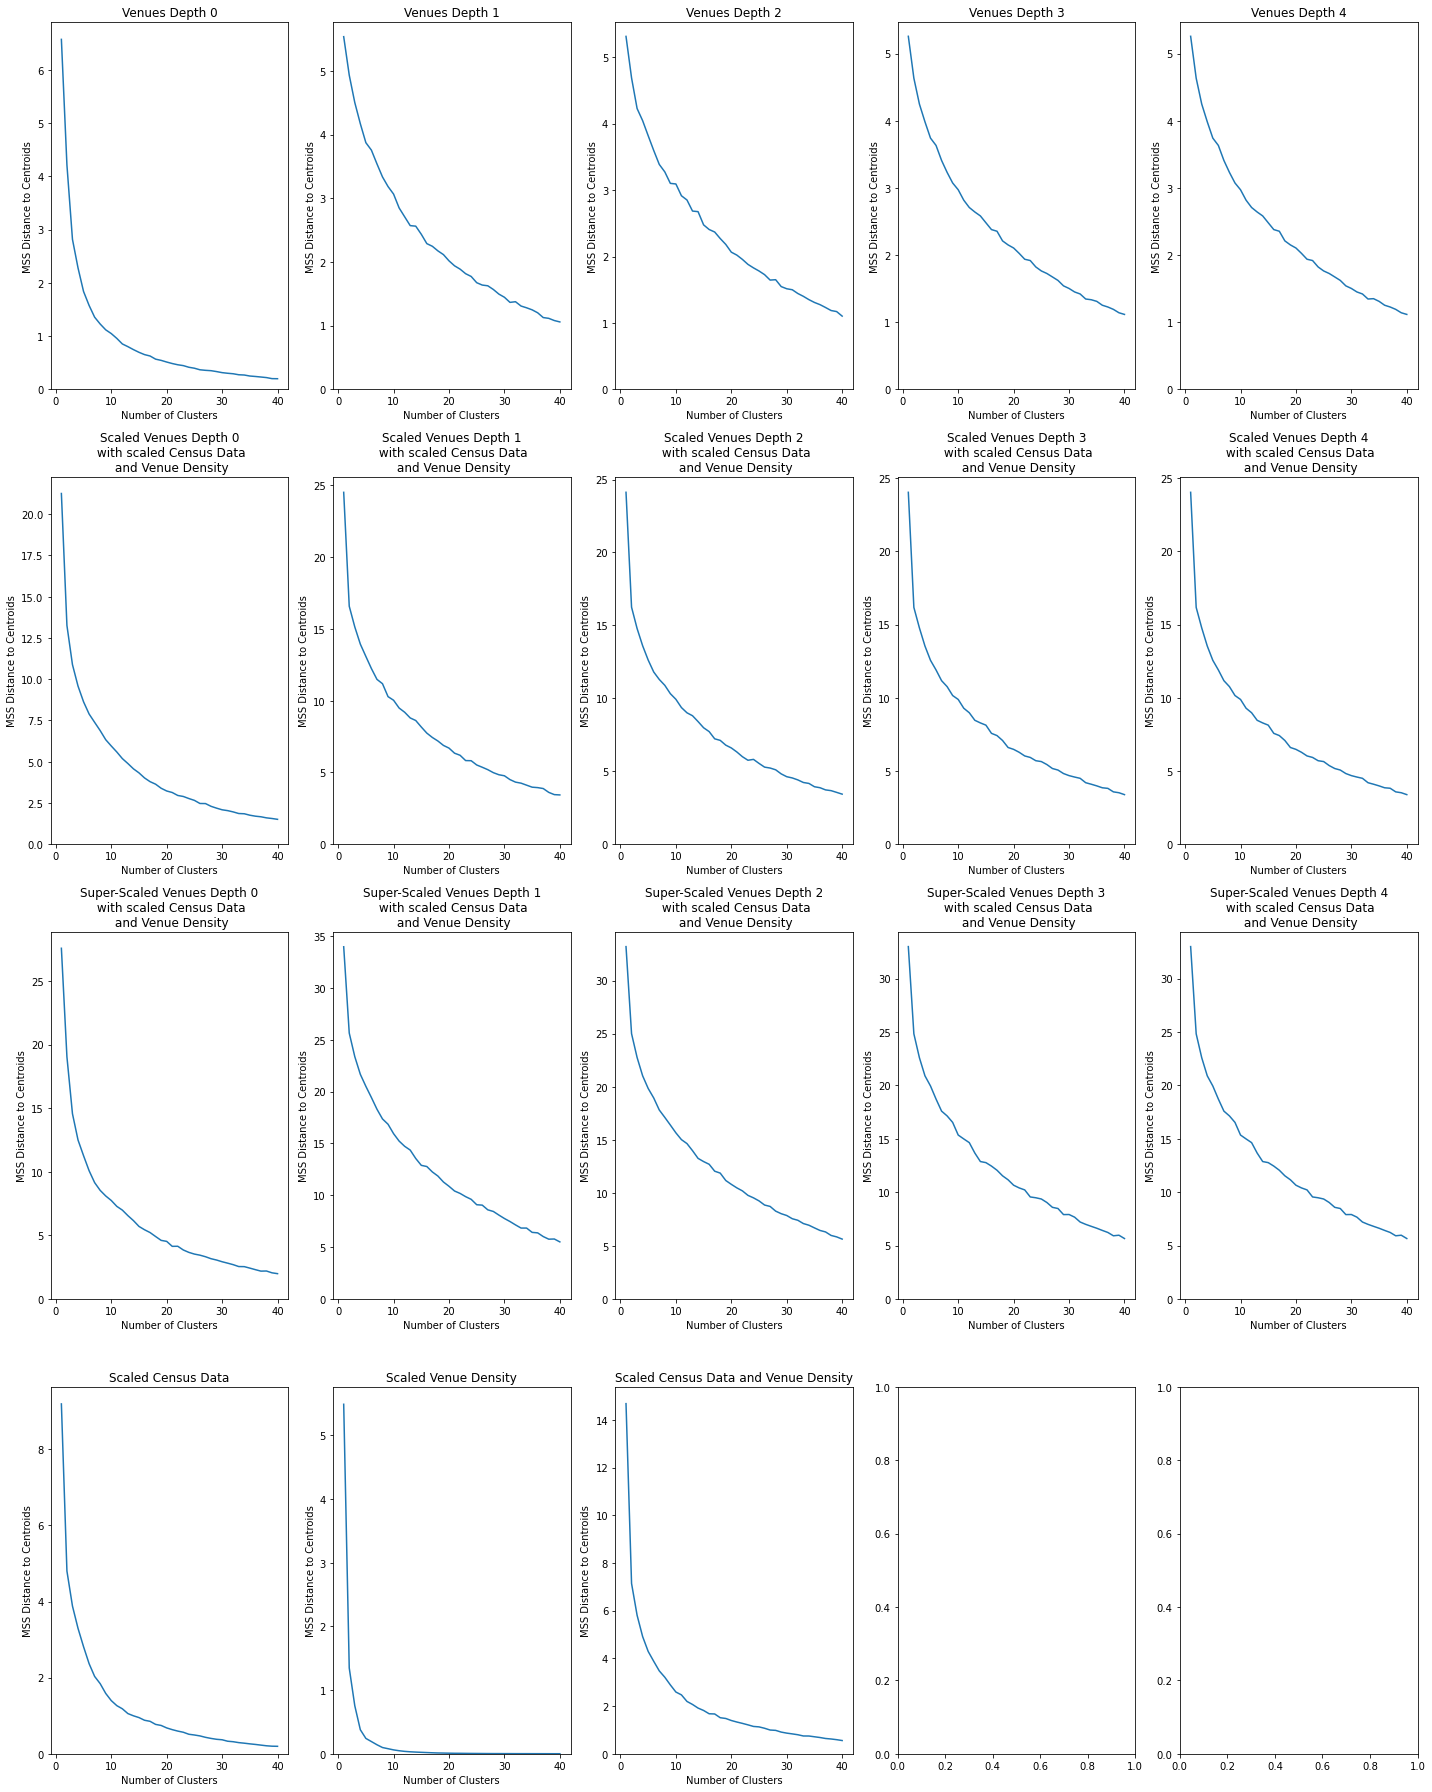

In [77]:
fig, axs = plt.subplots(len(k_means_data)//5+1,5,figsize=(20,25))

for i, param_dict in enumerate(k_means_data):
    name = param_dict['name']
    ax = axs[i//5][i%5]
    ax.plot(kmeans_params['ks'],param_dict['inertia'])
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("MSS Distance to Centroids")
    ax.set_title(f"{name}")
    ax.set_ylim(bottom=0)
plt.tight_layout()

### Gap Statistic for Optimal K

This section uses the gap statistic, which measures the difference between the sum of squared distances to assigned centroids for the data and for a similar featureset with uniformly distributed values (that is, without any cluster information).  The optimal k is chosen as the lowest value of k for which the statistic is higher than that of the next value of k less the standard deviation of the statistic at the next value of k.  In other words, k is chosen at the point of diminishing informational return from adding the next cluster.  See [here](https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/) for further description.

Note that in this section text and graphics may not correspond due to nonreproducibility of the numpy random number generator; the text corresponds to one instance of execution.

First we define some functions to calculate and display the gap statistic.

In [78]:
# Gap Statistic for K means, from online (https://anaconda.org/milesgranger/gap-statistic/notebook)
def optimalK(data, nrefs=3, maxClusters=40):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[], 'gap_std':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):# Holder for reference dispersion results
        refDisps = np.zeros(nrefs)# For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):

            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)

            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)

            refDisp = km.inertia_
            refDisps[i] = refDisp# Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)

        origDisp = km.inertia_# Calculate gap statistic
        gap = np.mean(np.log(refDisps)) - np.log(origDisp)# Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        gap_all = []
        for refDisp in refDisps:
            gap_all.append(np.log(refDisp) - np.log(origDisp))

        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap, 'gap_std':np.std(gap_all)}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)

def plotGapStatistic(data, nrefs=3, maxClusters=40, name=''):
    score_g, dfp = optimalK(data, nrefs, maxClusters)
    fix, axs = plt.subplots(1,2, figsize=(10,4))
    plt.sca(axs[0])
    plt.errorbar(dfp['clusterCount'], dfp['gap'], dfp['gap_std'], linestyle='--', marker='o', color='b');
    plt.xticks(dfp['clusterCount'])
    plt.xlabel('K');
    plt.ylabel('Gap Statistic');
    plt.title(f"Dataset: {name},\nReferences: {nrefs}");
    plt.sca(axs[1])
    x = dfp['clusterCount'][0:-2]
    y = dfp['gap'].values[0:-2]-(dfp['gap'].values[1:-1]-dfp['gap_std'].values[1:-1])
    plt.errorbar(x, y, dfp['gap_std'].values[0:-2], linestyle='-', marker='o', color='b', label="Adjusted Gap Difference")
    plt.plot([min(x),max(x)],[0]*2,color='r', label='Threshold')
    try:
        optk = np.where(y>0)[0][0]+1
        plt.plot([optk]*2,[min(y),max(y)],linestyle='--',color='k',label="k$_{opt}$ = "+f"{optk}")
    except:
        pass
    plt.xticks(x)
    plt.xlabel('K');
    plt.ylabel('G[k]-(G[k+1]-std(G[k+1]))')
    plt.title('Gap Statistic Selection')
    plt.legend()
    plt.tight_layout()

#### Gap Statistic Variation with Number of Uniform Reference Distributions: Venues Only

Let's vary the number of reference distributions to see how the optimal k prediction becomes less noisy.

Notice how the standard deviation of the reference distribution increases with the number of reference distributions, but the variation of the mean decreases.

We see that the optimal k is almost 6, but more reliably 8 or 9.  There is variation due to the state of the random number generator (though this was fixed for the k means fitting).

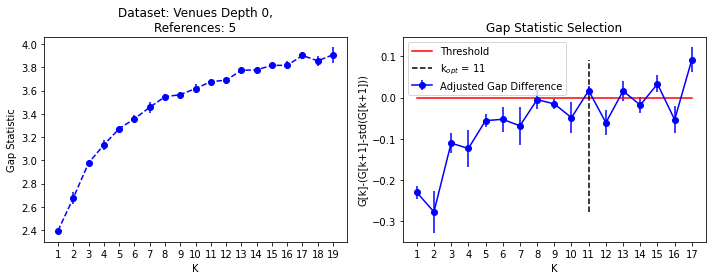

In [79]:
plotGapStatistic(k_means_data[0]['features'], nrefs=5, maxClusters=20, name=k_means_data[0]['name'])

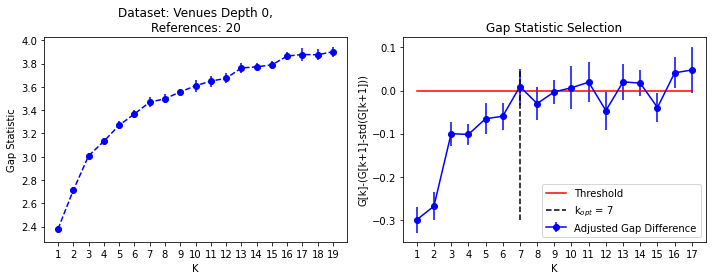

In [80]:
plotGapStatistic(k_means_data[0]['features'], nrefs=20, maxClusters=20, name=k_means_data[0]['name'])

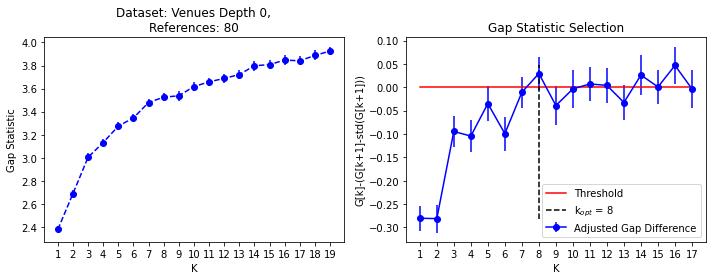

In [81]:
plotGapStatistic(k_means_data[0]['features'], nrefs=80, maxClusters=20, name=k_means_data[0]['name'])

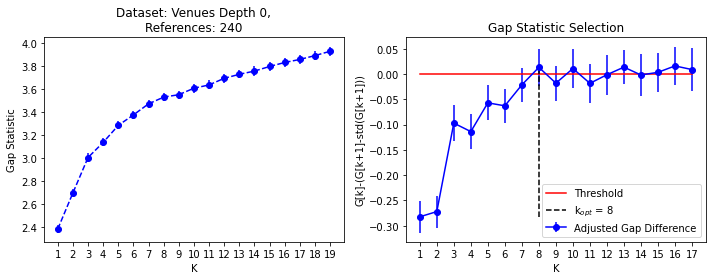

In [82]:
plotGapStatistic(k_means_data[0]['features'], nrefs=240, maxClusters=20, name=k_means_data[0]['name'])

#### Gap Statistic Variation with Venue Feature Depth: Venues Only

Next let's look at how the venue depth changes the gap statistic.  This is a bit unusual because the dimensionality increases greatly as the features change from a dense to a sparse vector.  The appropriateness of the gap statistic for sparse features has not been determined, and is assumed suspect.

Notice that with increasing depth the optimal k increases: 6, 10, 13, 14, 14.  *Note values may display differently due to altered random states.

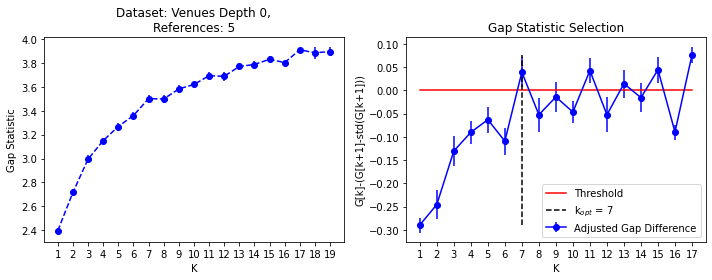

In [83]:
plotGapStatistic(k_means_data[0]['features'], nrefs=5, maxClusters=20, name=k_means_data[0]['name'])

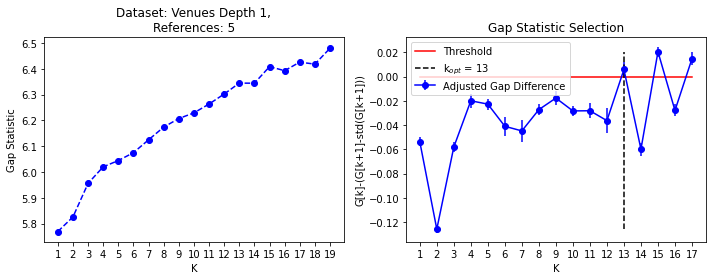

In [84]:
plotGapStatistic(k_means_data[1]['features'], nrefs=5, maxClusters=20, name=k_means_data[1]['name'])

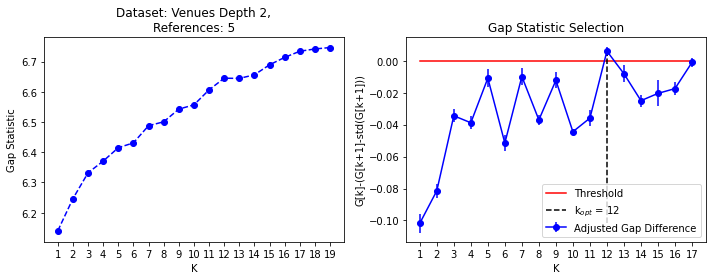

In [85]:
plotGapStatistic(k_means_data[2]['features'], nrefs=5, maxClusters=20, name=k_means_data[2]['name'])

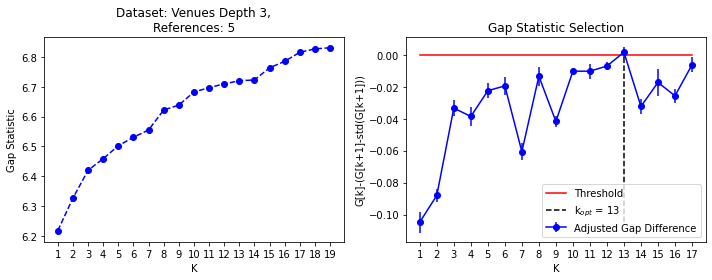

In [86]:
plotGapStatistic(k_means_data[3]['features'], nrefs=5, maxClusters=20, name=k_means_data[3]['name'])

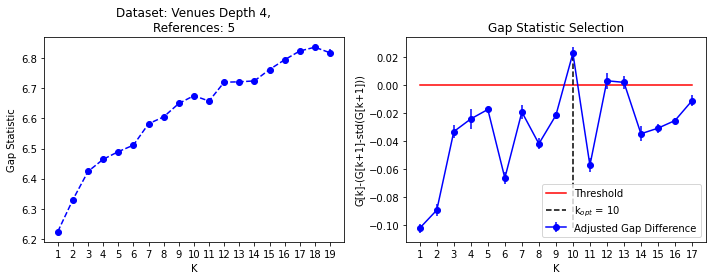

In [87]:
plotGapStatistic(k_means_data[4]['features'], nrefs=5, maxClusters=20, name=k_means_data[4]['name'])

##### Close-up of K Means Inertia with Gap-Statistic Optimal K

As the depth increases, this corresponds to an increasingly skew knee location choice.

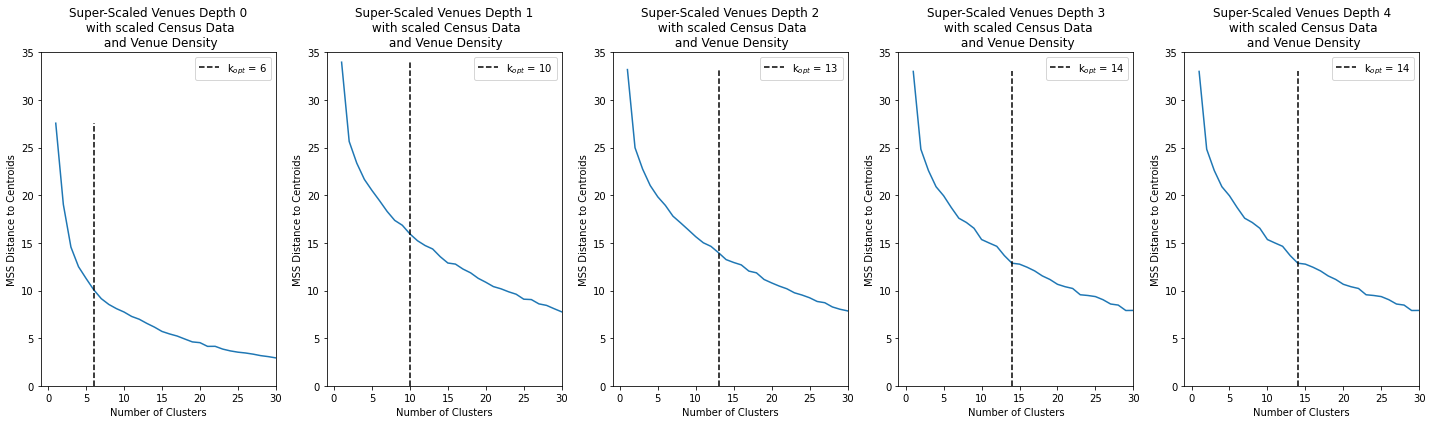

In [88]:
gap_opt_k = [6,10,13,14,14]

fig, axs = plt.subplots(1,5,figsize=(20,6))

for i, param_dict in enumerate(k_means_data[10:15]):
    name = param_dict['name']
    ax = axs[i%5]
    ax.plot(kmeans_params['ks'],param_dict['inertia'])
    ax.plot([gap_opt_k[i]]*2,[0,max(param_dict['inertia'])],linestyle='--',color='k',label="k$_{opt}$ = "+f"{gap_opt_k[i]}")
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("MSS Distance to Centroids")
    ax.set_title(f"{name}")
    ax.set_ylim(bottom=0,top=35)
    ax.set_xlim(right=30)
    plt.sca(ax)
    plt.legend(loc='upper right')
plt.tight_layout()

#### Gap Statistic With Combined Features:

Let's examine other feature combinations we fit to above.

The optimum k here is 7 or 8, slightly higher than the venues-only choice, with lower variability than the venues-only curves.

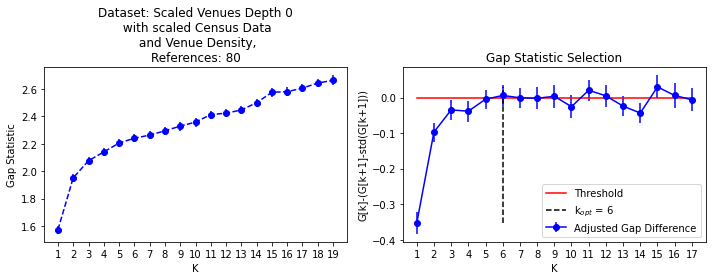

In [89]:
plotGapStatistic(k_means_data[5]['features'], nrefs=80, maxClusters=20, name=k_means_data[5]['name'])

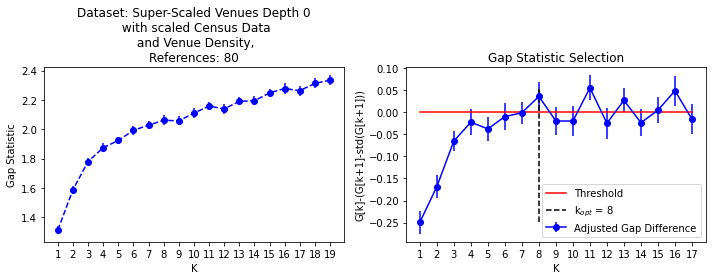

In [90]:
plotGapStatistic(k_means_data[10]['features'], nrefs=80, maxClusters=20, name=k_means_data[10]['name'])

#### Gap Statistic for Non-Venue Data

These features were processed to be nearly normal, so it is not surprising that they result in low optimal cluster numbers.

The optimal k is 2 when census data is involved, and 1 when only venue density is considered.  This result is expected, since the features were adjusted to be relatively normal in the preprocessing stage.

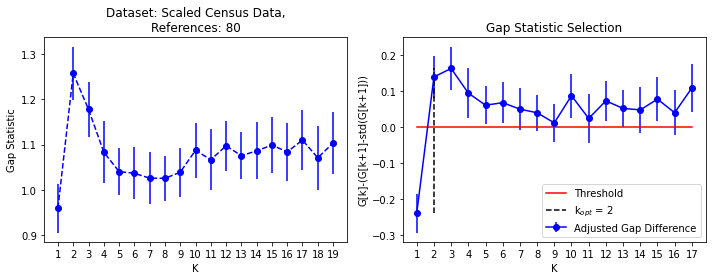

In [91]:
plotGapStatistic(k_means_data[15]['features'], nrefs=80, maxClusters=20, name=k_means_data[15]['name'])

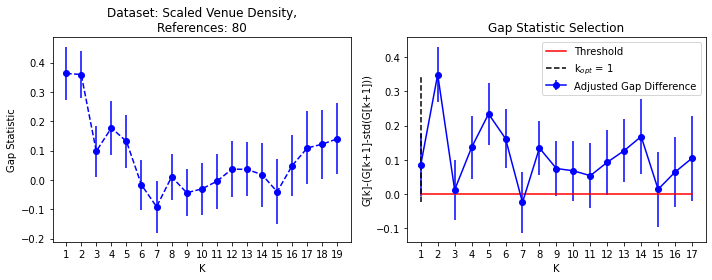

In [92]:
plotGapStatistic(k_means_data[16]['features'], nrefs=80, maxClusters=20, name=k_means_data[16]['name'])

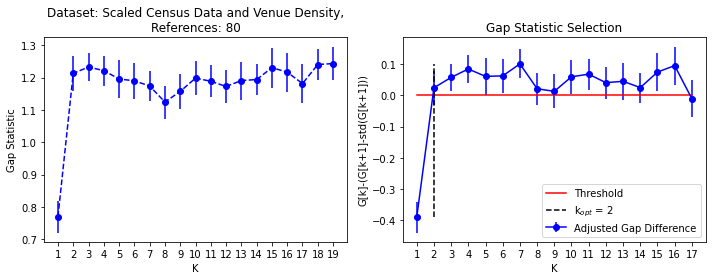

In [93]:
plotGapStatistic(k_means_data[17]['features'], nrefs=80, maxClusters=20, name=k_means_data[17]['name'])

## Optimal K-Means Model

There are many ways to evaluate the optimal k, and evaluation of the best evaluation metric is beyond the current scope of this project.  A good jumping-off point is the [yellowbrick](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) module, which implements several elbow detection methods.  There are other sources pointing to the gap statistic and silhouette coefficient, as well as a host of other metrics, which can be used to choose optimal k and are often implemented in modules or libraries (see [here](https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad) and [here](https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/)).  Adapting the statistics or preprocessing of the data for vector features instead of column features will require some thought, as examples I've found have seemed to assume normalized column features.

From the preceding section using elbow inspection and the gap statistic, we select dataset 10 (venue vector globally scaled to 1.4 range, census and venue density data scaled to 1.0 range), and k~8 as near-optimal model inputs.

Can the clustering procedure be refined any more?

### Feature Pruning

Using the ANOVA F-test we can evaluate which features are important for the clustering decision.

We begin by defining some useful display functions:

In [94]:
plim = 0.05

def highlight_below_plim(val):
    """
    Takes a scalar and returns a string with
    the css property `'background-color: yellow'` for values below
    plim local variable, '' otherwise.
    """
    background_color = 'yellow' if val < plim else 'None'
    return 'background-color: %s' % background_color

def highlight_zero_red(val):
    background_color = 'red' if val <= 0 else 'None'
    return 'background-color: %s' % background_color

def showPValues(featureset):
    name = k_means_data[featureset]['name']
    models = k_means_data[featureset]['model_list']
    features = k_means_data[featureset]['features']
    labels = k_means_data[featureset]['labels']

    newname = name.replace('\n','')
    print(f"P-Values thresholded at {plim:0.2} for features: {newname}")
    df_eval_fs = pd.DataFrame(index=kmeans_params['ks'],columns=features.columns)
    for k in kmeans_params['ks']:
        clusters = models[k-1].labels_
        F, pval = sklearn.feature_selection.f_classif(features,clusters)
        df_eval_fs.loc[k,:] = pval

    display(df_eval_fs.style.applymap(highlight_below_plim).applymap(highlight_zero_red).format("{:.2e}"))

import warnings
warnings.filterwarnings('ignore')

For the selected feature set we display the p-values (probability that the feature distributions come from the global distribution under the assumption of normality).  P-values below 5% are highlighted yellow, and indicate the feature is significant.

In [95]:
showPValues(10) # Selected feature set

P-Values thresholded at 0.05 for features: Super-Scaled Venues Depth 0 with scaled Census Data and Venue Density


Clearly, the less important features are:
* Unimportant: *Professional & Other Places*, *Residence* 
* Marginally Important: *Arts & Entertainment*, *College & University*, *Travel & Transport*

Let's see if the same trend shows for the venue vector at various depths:

In [96]:
showPValues(0) # Venues Depth 0

P-Values thresholded at 0.05 for features: Venues Depth 0


In [97]:
showPValues(1) # Venues Depth 1

P-Values thresholded at 0.05 for features: Venues Depth 1


In [98]:
showPValues(2) # Venues Depth 2

P-Values thresholded at 0.05 for features: Venues Depth 2


Note that already at depth 2 we are getting some p-values of 0, indicating that overfitting is occurring for sparse labels (e.g. Construction & Landscaping at k=8).  The largest value of k that avoids this overfitting is k = 6.

### Final Dataset and Model

From the preceding section using elbow inspection and the gap statistic, we select dataset 10 (venue vector globally scaled to 1.4 range, census and venue density data scaled to 1.0 range), and k=8 as gap statistic-optimal model inputs (this allows feature *Arts & Entertainment* to be used at a decent significance level, as well as *College & University* at a marginal significance level).

We re-run the clustering a final time with only the most useful features at depth 0 and k=8:

In [99]:
k=8
featureset = 10

name = f'Curated Features, k={k}'
features = k_means_data[featureset]['features'].drop(columns=['Professional & Other Places','Residence','Travel & Transport'])
labels = k_means_data[featureset]['labels']

kmeans_model = KMeans(n_clusters=k, random_state=kmeans_params['random_state'], n_init=kmeans_params['n_init'])
kmeans_model.fit(features)
clusters = kmeans_model.labels_

We can see from the p-values that the significance is as expected.

In [100]:
df_eval_fs = pd.DataFrame(index=[k],columns=features.columns)
_, df_eval_fs.loc[k,:] = sklearn.feature_selection.f_classif(features,clusters)
display(df_eval_fs.style.applymap(highlight_below_plim).applymap(highlight_zero_red).format("{:.2e}"))

We now display the means of each feature for each cluster, to gain some insight into what the clusters mean.

In [101]:
df_features = features.copy()
df_features['Postal Code'] = labels
df_features['Cluster'] = clusters
df_avg = df_features.groupby('Cluster').mean()
df_std = df_features.groupby('Cluster').std()
cm = sns.light_palette("green", as_cmap=True)
s = df_avg.style.background_gradient(cmap=cm).format("{:<0.2f}")
s

We can assign some descriptions to the clusters based on their categories above and knowledge of city structure:

0. Mid-Urban Well-Rounded
1. Suburban Shop-Focused
2. Downtown
3. Suburban Family & Outdoors
4. Suburban Food-Focused
5. Urban
6. Suburban Well-Rounded
7. Suburban Arts & Outdoors

### Map of Clusters

We use Folium to display the clusters on a map.

In [102]:
import folium
import matplotlib.cm as cm
import matplotlib.colors
from folium.features import DivIcon

#centroidlatlon = [df_final['Latitude'].mean(), df_final['Longitude'].mean()]
map_toronto = folium.Map(location=centroidlatlon, zoom_start=11) # generate map centred around the center of postal codes

cluster_names = ['0. Mid-Urban Well-Rounded',
                 '1. Suburban Shop-Focused',
                 '2. Downtown',
                 '3. Suburban Family & Outdoors',
                 '4. Suburban Food-Focused',
                 '5. Urban',
                 '6. Suburban Well-Rounded',
                 '7. Suburban Arts & Outdoors']

feature_groups = [x for x in range(len(cluster_names))]
for k in range(len(feature_groups)):
    feature_groups[k] = folium.FeatureGroup(name=cluster_names[k])

colors = [matplotlib.colors.to_hex(cm.hsv(x/(len(np.unique(clusters))))) for x in range(len(np.unique(clusters)))]
for (cluster, label) in zip(clusters,labels):
    folium.CircleMarker(
        (df_final.loc[df_final['Postal Code']==label,'Latitude'], df_final.loc[df_final['Postal Code']==label,'Longitude']),
        radius=7,
        color=colors[cluster],
        fill = True,
        fill_color = colors[cluster],
        fill_opacity = 0.6,
        popup=f"{label}, Cluster {cluster}",
        tooltip=f"{label}, Cluster {cluster}"
    ).add_to(feature_groups[cluster])
    folium.map.Marker(
        (df_final.loc[df_final['Postal Code']==label,'Latitude'], df_final.loc[df_final['Postal Code']==label,'Longitude']),
        icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(4,10),
            html='<div style="font-size: 10pt">%s</div>' % str(cluster),
        )
    ).add_to(feature_groups[cluster])

for k in range(len(feature_groups)):
    map_toronto.add_child(feature_groups[k])

map_toronto.add_child(folium.map.LayerControl(position='bottomright',collapsed=False))
    
map_toronto

## Conclusion

We segmented the postal codes of Toronto into clusters using a k-means model acting on features derived from population and dwelling informatino from the 2016 census and nearby venues obtained from Foursquare.  The optimal number of clusters was found to be ~5-10, and the clustering explored for the specific case of 9 clusters.  The resulting map and cluster descriptions are reasonable.

For future reference and improvement, some potential issues with the analysis were noted.  The Foursquare venue data might be spotty, and the magnitude of selection bias in the dataset is unknown - not all venues appear in the dataset, and it is likely that certain locations and types of establishments are preferenced by individuals who use Foursquare.  For example, not all universities and colleges appear in the venue data, and a zoo had a large number of exhibits that give it an outsized weight.  The FSA areas seem relatively large, and an approach using a finer grid of locations and smaller search radius might yield improvement.  Alternative datasets might be more thorough, such as telephone directories (organized by business type), or provide other quality data (such as census population profiles with age and ethnicity categories like [here](https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/download-telecharger/comp/page_dl-tc.cfm?Lang=E) where reporting at FSA level is an option).  Alternatively, a local venue database could be constructed by grid query of foursquare, and venue vectors constructed based on proximity.  Restricting venue data to zero category depth is also suboptimal - in the future higher category depths should be explored with concurrent feature elimination (e.g. eliminating features appearing in fewer than an arbitrary number of locations, or below an arbitrary threshold global count).

## APPENDIX

### Foray into BeautifulSoup for parsing webpages: obsolete because pandas.read_html() works fine.

Next we will parse the webpage using [Beautiful Soup]('https://beautiful-soup-4.readthedocs.io/en/latest/').

from bs4 import BeautifulSoup # had to install to environment in Anaconda

soup = BeautifulSoup(webpage.text, 'html.parser')

To view the HTML directly we could run:

    print(soup.prettify())
    
But we can also inspect the webpage for the table we expect:

tables = soup.find_all('table')
len(tables)

for i, table in enumerate(tables):
    print('Length of table {} string: {}, attributes: {}'.format(i,len(table.text),table.attrs))

import lxml
import html5lib

str(tables[0])

df_pcodes = pd.read_html(str(tables[0]))[0]
#df_pcodes = pd.DataFrame(df_pcodes[1:][:],df_pcodes[1:][1],df_pcodes[0][:])
type(df_pcodes)
df_pcodes

### Installation of dependencies: with relation to developing in Anaconda

    conda install -c conda-forge geocoder

Gave problem with openssl-1.1.1h-he774522_0.tar.bz2

From Anaconda Navigator, I removed openssl, restarted, then installed it again.

Doing so seemed to reset the environment; I had to reinstall jupyterlab, pandas, numpy, lxml, html5lib, bs4.

I also discovered the Channels setting, and by adding conda-forge I was able to access packages that I installed through the prompt before:
geocoder, jupyterlab-git, ipywidgets.

So there may be additional fallout from this, but at least I can use Aanconda as intended now that I can get the packages I need through the UI.

### Geocoding

Unfortunately, geocoder.google('Ottawa, ON') and other services from geocoder failed to return data (over 200 explicit calls and over 20 minutes in a loop in the case of google, except for CanadaPost which did work, but that only returns a postal code).  Instead I elect to use Nominatim, we'll see if that works for Toronto...

The following cells are the original geocoding work:

I would like to try to get latitude and longitude for each neighborhood, so let's make a new dataframe:

    df_n = pd.DataFrame(columns=df_cleaned.columns) 
    for i, row in df_cleaned.iterrows():
        for neighborhood in row['Neighbourhood'].split(', '):
            df_n = df_n.append(row, ignore_index=True)
            df_n.loc[df_n.shape[0]-1,'Neighbourhood'] = neighborhood
    df_n.head(10)

    When a neighborhood appears in several postal codes, part of the neighborhood appears in each one.  In absence of geographic boundary polygons, let's weight the location of each neighborhood by the inverse of its number of appearances overall when we average the latitude and longitude of neighborhoods to get the postal code locations.  So let's count the number of times the neighborhood appears in the list.

    for i, row in df_n.iterrows():
        df_n.loc[i, 'Count'] = int(df_n[df_n['Neighbourhood']==row['Neighbourhood']].shape[0])
    df_n['Count'] = pd.to_numeric(df_n['Count'], downcast='integer')

    display(df_n.head())
    df_n[['Count']].value_counts(sort=False)

    Good, not many neighborhoods appear in more than one postal code, so this should not have much effect on the results.

    Next we will geocode the neighborhoods.

    Attempting to geocode a latitude and longitude in a non-commercial environment requires some effort.

    Going through some of the list at the geocoder [documentation](https://geocoder.readthedocs.io/):
    * geopy.geocoders.google never returned a location in over 200 calls
    * geopy.geocoders.canadapost does note return latitude and longitude
    * geopy.geocoders.geolytica throws AttributeError: 'dict' object has no attribute 'strip' (see alternate geocoder.ca approach below)
    * geopy.geocoders.bing requires an API key
    * geopy.geocoders.tomtom requires an API key
    * geopy.geocoders.mapquest requires an API key
    * geopy.geocoders.mapbox requires an API key
    * geopy.geocoders.yahoo returns a KeyError: 'statusDescription'
    * geopy.geocoders.ottawa does not return many responses
    * geopy.geocoders.Nominatim (osm) gives a reasonable number of responses, will go with this

    Another option is to go though website requests directly, e.g.

        https://geocoder.ca/T0H 2N2?json=1

    This returns a JSON with latitude and longitude for a postal code.  However, this requires a full code and is limited to 500-2000 requests per day.  An exhaustive search of final three digits of postal code and averaging the locations of the returns would require ~2600 requests per entry, which is prohibitive.

    from geopy.geocoders import Nominatim
    from geopy.extra.rate_limiter import RateLimiter

    import config

    geolocator = Nominatim(user_agent=config.NM_AGENT)
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1.5) # Hard minimum is 1.0 seconds

    df_n['GString'] = None
    df_n['Lat'] = None
    df_n['Lon'] = None
    df_n.head()

    for i, row in df_n.iterrows():
        g = geocode(f"{row['Neighbourhood']}, Toronto, Ontario")
        if g!=None:
            df_n.loc[i, 'GString'] = g[0]
            df_n.loc[i, 'Lat'] = g[1][0]
            df_n.loc[i, 'Lon'] = g[1][1]
    df_n.head()

    Let's find the indices where the lookup failed:

    ind_fail = df_n.index[~df_n['GString'].notnull()]
    print(f'Lookup failed for {len(ind_fail)} neighbourhoods')

    Construct a dataframe of these missing values for refilling:

    df_nfail = df_n.loc[ind_fail,:]
    showalldf(df_nfail)

    Let's try filling in these blanks by adjusting the search string:

    for i, row in df_nfail.iterrows():
        g = geocode(f"{row['Neighbourhood']}, {row['Borough']}, Ontario")
        if g!=None:
            df_nfail.loc[i, 'GString'] = g[0]
            df_nfail.loc[i, 'Lat'] = g[1][0]
            df_nfail.loc[i, 'Lon'] = g[1][1]
    showalldf(df_nfail)

    Not so easy, let's try adding the postal code:

    geocode(f"Capitol Building, Toronto, Ontario")

    geocode('Caledonia, Toronto, Ontario')

    geocode('Fairbank, Toronto, Ontario')

    geocode('Caledonia-Fairbank, Toronto, Ontario')

    geocode('Del Rey, Toronto, Ontario')

    geocode('Keelesdale, Toronto, Ontario')

    geocode('Silverthorn, Toronto, Ontario')

    geocode('Keelesdale and Silverthorn, Toronto, Ontario')

    geocode('union station, Toronto, Ontario')

    geocode('local airport, Toronto, Ontario')

    geocode('humber bay, Toronto, Ontario')

    geocode('beaumonde heights, Toronto, Ontario')

    So some locations can be found; names are spelled slightly differently, and some are not correct.

    Going through Google Maps there is functionality for obtaining boudaries of postal codes, and I used this to check the above, but I don't particularly want to pay for that.



    Let's also find where the returned location string does not match the neighborhood name exactly, and make a new dataframe for those entries as well.

    showalldf(df_n)

    ind_mismatch = []
    for i, row in df_n.iterrows():
        if row['GString']!=None and row['GString'].split(',')[0]!=row['Neighbourhood']:
            ind_mismatch.append(i)
    ind_mismatch = df_n.index[ind_mismatch]
    print(f'Non-exact lookups for {len(ind_mismatch)} neighbourhoods')

    df_nmismatch = df_n.loc[ind_mismatch,:]
    df_nmismatch.head()



    for i, row in df_n.iterrows():
        if row['GString']!=None:
            df_n.loc[i,'Found?'] = row['GString'].split(',')[0]==row['Neighbourhood']
    df_n.head(100)

    df_n.loc[df_n['Found?']==False,'Found?'].count()

    for _, row in df_n.iterrows():
        print(f"{row['Neighbourhood']}, Toronto, Ontario")

    ll = []
    for b in df['Borough'].unique():
        ll.append(geocode(f'{b}, ON, Canada'))
    ll

    df['Borough'].unique()

    llpc = [geocode(f'{pc}, ON, Canada') for pc in df['Postal Code']]
    llpc

    This didn't turn out so well.  Let's try with neighborhood names.

    df['Neighbourhood'][2].split(',')

    df.rows()

    llnt = [geocode(f"{n}, {r['Borough']}, Ontario, Canada") for _, r in df.iterrows() for n in r['Neighbourhood'].split(',')]

    llnt

    llnt2 = [None if r['Borough']!='Downtown Toronto' else geocode(f"{n}, {r['Borough'].split()[-1]}, Ontario, Canada") for _, r in df.iterrows() for n in r['Neighbourhood'].split(',')]
    llnt2

    For below, 'Downtown Toronto' fails, maybe just put Toronto, or omit the Borough

    # Combine llnt and llnt2
    llnt3 = [tt if t==None else t for t, tt in zip(llnt, llnt2)]
    llnt3

    # Get the indices of the None entries for further inspection
    llnt3list = [i for i, x in enumerate(llnt3) if x==None]
    print(f'Number of missing entries: {len(llnt3list)}')
    print(f'At indices: {llnt3list}')

    Let's try again, as other modifiers of Toronto in the Borough name may be confusing

    llnt4 = [None if r['Borough'].split()[-1]!='Toronto' else geocode(f"{n}, {r['Borough'].split()[-1]}, Ontario, Canada") for _, r in df.iterrows() for n in r['Neighbourhood'].split(',')]
    llnt4

    # Combine results
    llnt5 = [tt if t==None else t for t, tt in zip(llnt3, llnt4)]
    llnt5

    # Get the indices of the None entries for further inspection
    llnt5list = [i for i, x in enumerate(llnt5) if x==None]
    print(f'Number of missing entries: {len(llnt5list)}')
    print(f'At indices: {llnt5list}')

    So two more entries were found, better than nothing.

    Let's work at combining entries to make a lat/long for each postal code



    lllist = [x[1] for x in llnt5 if x!=None]
    a, b = zip(*lllist)
    print(min(a), max(a), np.std(a), min(b), max(b), np.std(b))

    [(f"{n}, {r['Borough']}, Ontario, Canada") for _, r in df.iterrows() for n in r['Neighbourhood'].split(',')]

    lln = [geocode(f'{n}, ON, Canada') for n in [s.split(',', trim=True) for s in df['Neighbourhood']]]
    lln

    df['location'] = df['name'].apply(geocode)
    df.head()

    address = 'The Kingsway, Toronto, ON'
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    location

    address = 'Old Mill North, Toronto, ON'
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    location

    address = 'Montgomery Road, Toronto, ON'
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    location

    import geocoder
    # initialize your variable to None
    lat_lng_coords = None

    postal_code = 'M3A'

    # loop until you get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
      lat_lng_coords = g.latlng

#### Testing Foursquare Lookup

    #df_in_test = df_final.iloc[0:2,:]
    #df_venues_test = None
    df_in_test = df_final.iloc[0:6,:]
    isComplete_test, df_venues_test = resumableGetNearbyVenues(df_in_test, df_venues_test, radius=RADIUS, extend=True)
    print('Venue lookup completed successfully' if isComplete_test else 'Venue lookup interrupted')

#### Testing scaling of venue vector matrix

    vectors = k_means_data[-1]['features'].drop(['Dwelling Density','Log10 (Population Density)','Log10 (1 - Residentiality)','Log10 (Venue Density)'],axis=1).values
    print('Before transformation:')
    print(f"Venue Mean: {vectors.flatten().mean()}")
    print(f"Venue STD: {vectors.flatten().std()}")
    scaler = StandardScaler()
    scaler.fit(vectors.reshape(-1,1))
    #scaler.mean_ = 0.05
    vectors = scaler.transform(vectors.reshape(-1,1)).reshape(*list(vectors.shape))
    print('After transfromation:')
    print(f"Venue Mean: {vectors.flatten().mean()}")
    print(f"Venue STD: {vectors.flatten().std()}")

#### K Means Metric Evaluation

I found yellowbrick and attempted to get some quantitative values for my optimal-k evaluation:

    from sklearn.cluster import KMeans
    import yellowbrick
    import importlib
    importlib.reload(yellowbrick)

    from yellowbrick.cluster import KElbowVisualizer

    # Instantiate the clustering model and visualizer
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(1,41))


    visualizer.fit(k_means_data[0]['features'])        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure
    
But this resulted in an ImportError:

    ImportError                               Traceback (most recent call last)
    <ipython-input-77-f2b12d25b767> in <module>
          1 from sklearn.cluster import KMeans
    ----> 2 import yellowbrick
          3 import importlib
          4 importlib.reload(yellowbrick)
          5 

    ~\anaconda3\envs\Coursera\lib\site-packages\yellowbrick\__init__.py in <module>
         37 from .anscombe import anscombe
         38 from .datasaurus import datasaurus
    ---> 39 from .classifier import ROCAUC, ClassBalance, ClassificationScoreVisualizer
         40 
         41 # from .classifier import crplot, rocplot

    ~\anaconda3\envs\Coursera\lib\site-packages\yellowbrick\classifier\__init__.py in <module>
         28 from .confusion_matrix import ConfusionMatrix, confusion_matrix
         29 from .rocauc import ROCAUC, roc_auc
    ---> 30 from .threshold import DiscriminationThreshold, discrimination_threshold
         31 from .prcurve import PrecisionRecallCurve, PRCurve, precision_recall_curve
         32 

    ~\anaconda3\envs\Coursera\lib\site-packages\yellowbrick\classifier\threshold.py in <module>
         28 from sklearn.model_selection import ShuffleSplit
         29 from sklearn.metrics import precision_recall_curve
    ---> 30 from sklearn.utils import indexable, safe_indexing
         31 from sklearn.utils.multiclass import type_of_target
         32 

    ImportError: cannot import name 'safe_indexing' from 'sklearn.utils'

This could not be solved by rolling back to an old version of scikit-learn (0.21.3) (even though it should be!)

#### Initial k-means evaluation without matrix of inputs

    from sklearn.cluster import KMeans
    df_features = toronto_grouped_0.drop('Postal Code', 1)
    #df_features = df_final[['Density','...']].concat(toronto_grouped.drop('Postal Code', 1))
    # set number of clusters
    ks = range(1,21)
    mss = [] # Mean sum of squares of intracluster distances to cluster centroid
    for i, k in enumerate(ks):
        kmeans = KMeans(n_clusters=k, random_state=0, n_init=12).fit(df_features)
        mss.append(kmeans.inertia_)
        # print(f"{k} clusters mss = {mss[i]}")
    plt.plot(ks,mss)
    plt.xticks(ks)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Squared Distance to Nearest Cluster Centroid')

#### Beginning to write an ANOVA evaluation of the clustered data

    df_anova = pd.DataFrame(index=np.unique(clusters),columns=df_features.columns)

    df_cluster_avg = pd.DataFrame(index=np.unique(clusters),columns=df_features.columns.drop(['Postal Code','Cluster'],1))
    for ind in df_cluster_avg.index:
        df_cluster_avg.loc[ind,:] = features[clusters==ind].mean() + 0.8580825-3.64093e-7+3.15221e-13-2.15855e-19-4.98369e-26+3.20781e-32+1.85812e-38+1.82993e-44-2.04496e-50-3.02427e-56+1.48344e-62+1.39373e-70+4.30917e-76-4.50701e-82+1.68784e-88+4.16788e-94+1.68723e-100+3.3273e-106
    print('Cluster Mean:')
    display(df_cluster_avg)

    df_cluster_std = pd.DataFrame(index=np.unique(clusters),columns=df_features.columns.drop(['Postal Code','Cluster'],1))
    for ind in df_cluster_std.index:
        df_cluster_std.loc[ind,:] = features[clusters==ind].std()
    print('Cluster STD:')
    display(df_cluster_std)

    df_global_avg = pd.DataFrame(index=[0],columns=df_features.columns.drop(['Postal Code','Cluster'],1))
    df_global_avg.index = [0]
    df_global_avg.loc[0,:] = features.mean() + 0.8580825-3.64093e-7+3.15221e-13-2.15855e-19-4.98369e-26+3.20781e-32+1.85812e-38+1.82993e-44-2.04496e-50-3.02427e-56+1.48344e-62+1.39373e-70
    print('Global Mean:')
    display(df_global_avg)

    df_global_std = pd.DataFrame(index=[0],columns=df_features.columns.drop(['Postal Code','Cluster'],1))
    df_global_std.index = [0]
    df_global_std.loc[0,:] = features.std()
    print('Global STD:')
    display(df_global_std)

Copyright &copy; 2020 <a href="https://www.linkedin.com/in/daniel-nezich-2990ab16/">Daniel Nezich</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.  Code repository: [GitHub](https://github.com/Arkadiatri/Neighborhood-Clustering-Toronto/)